#### Student Name: Juntang Wang
#### Student ID: jw853

# <span style="color:blue"># Part I</span>

## Problem 1. backpropagation

---



### Solution:

The forward pass can be described as:

- Linear layer: $z_1 = w_1 x,\quad z_2 = w_2 x$
- Activation function: $h_1 = \sigma(z_1),\quad h_2 = \sigma(z_2)$
- Output layer: $y = h_1 + h_2$

As we want $\partial y / \partial x$, we can use the chain rule to get:

\begin{equation*}
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial h_1} \frac{\partial h_1}{\partial z_1} \frac{\partial z_1}{\partial x} + \frac{\partial y}{\partial h_2} \frac{\partial h_2}{\partial z_2} \frac{\partial z_2}{\partial x}
\end{equation*}

For each of the terms, we have:

- $\frac{\partial y}{\partial h_1} = 1$
- $\frac{\partial y}{\partial h_2} = 1$
- $\frac{\partial h_1}{\partial z_1} = \sigma'(z_1)$
- $\frac{\partial h_2}{\partial z_2} = \sigma'(z_2)$
- $\frac{\partial z_1}{\partial x} = w_1$
- $\frac{\partial z_2}{\partial x} = w_2$

Thus we have:

\begin{equation*}
\frac{\partial y}{\partial x} = \sigma'(z_1) w_1 + \sigma'(z_2) w_2
\end{equation*}


## Problem 2. batch normalization

In "Lecture 2 Notebook 1", we defined a neural network with the following architecture: 
[input] -> Linear(28x28, 512) -> ReLU -> Linear(512, 512) -> ReLU* -> Linear(512, 10) -> ReLU -> [output]

In this exercise, we try to reproduce Page 3 of Lecture 2's slides. First, use the above network to train for 50 epochs. 
Plot the histogram of activation values of the second linear layer (the values of "*" above), versus epochs.

Then, add batch normalization as in "Lecture 2 Notebook 1". Plot the histogram of the activation after the
second batch normalization, versus epochs.

Compare the two plots.

---



### Solution: 

below we define the nn using the provided code


  0%|          | 0/50 [00:00<?, ?it/s]

Test Error: Accuracy: 79.5%, Avg loss: 1.052326


  0%|          | 0/50 [00:00<?, ?it/s]

Test Error: Accuracy: 88.5%, Avg loss: 1.055724


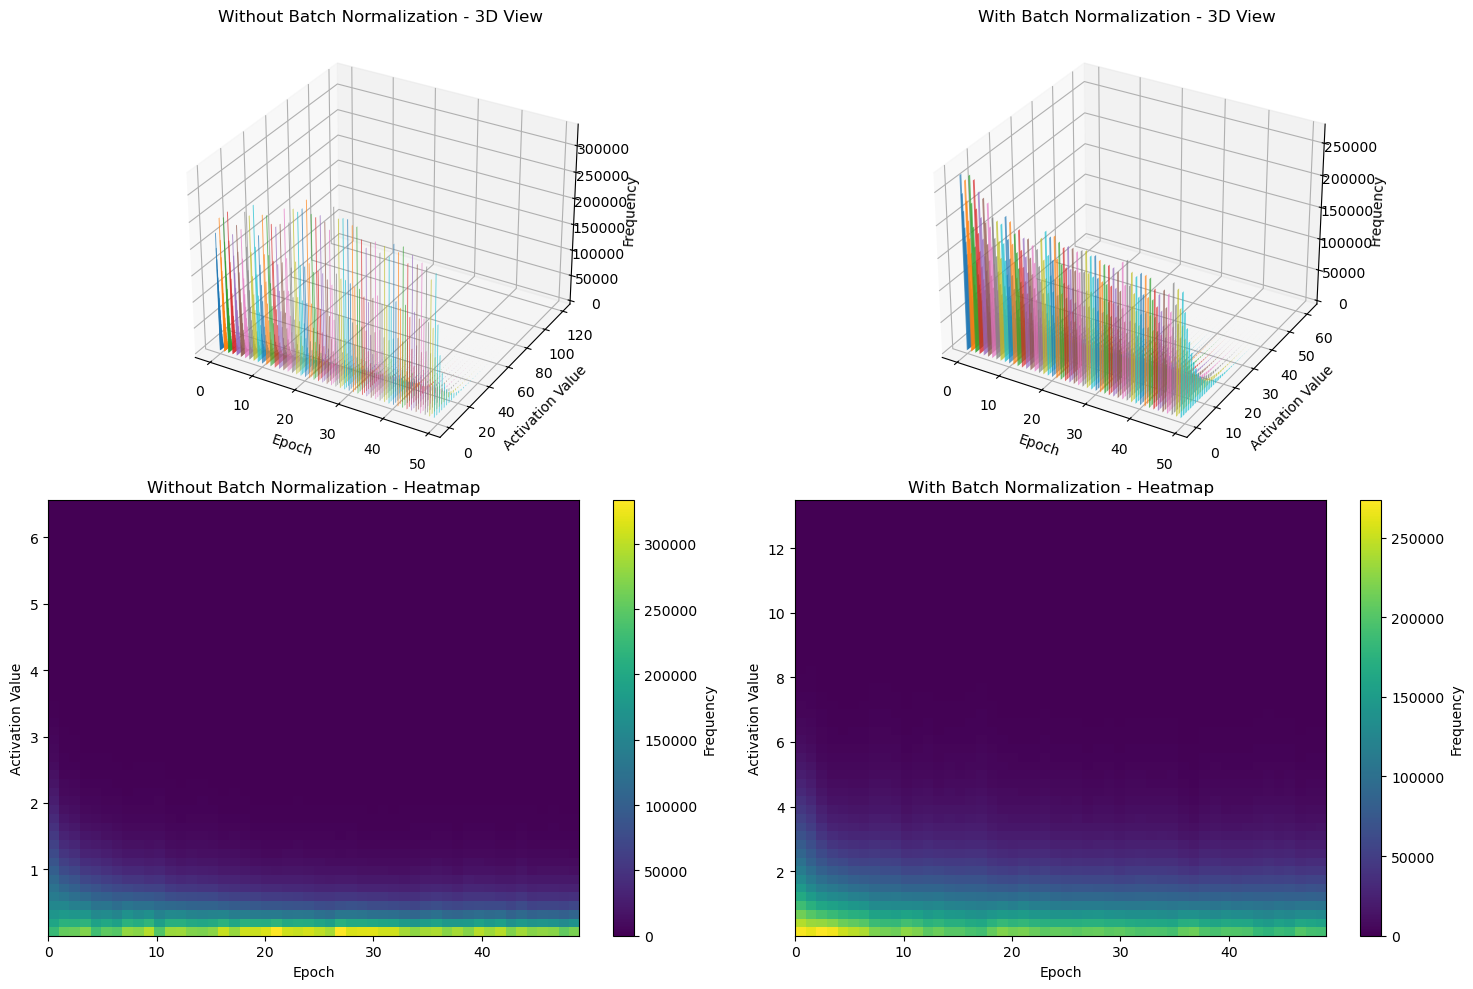

Done!


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, use_batchnorm=0):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.use_batchnorm = use_batchnorm
        layers = [
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(), # this is the * in the question
            nn.Linear(512, 10),
            nn.ReLU()
        ]
        if use_batchnorm:
            layers.insert(1, nn.BatchNorm1d(512))
            layers.insert(3, nn.BatchNorm1d(512))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

    def get_star_values(self, x):
        x = self.flatten(x)
        num_layers = 4 + 2*self.use_batchnorm # +1 for batchnorm
        x = self.linear_relu_stack[:num_layers](x)
        return x

training_data = datasets.FashionMNIST(root="data", train=True, download=True,transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True,transform=ToTensor())
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

def train_loop(dataloader, model, loss_fn, optimizer):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
def star_values(dataloader, model):
    activations = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            batch_activations = model.get_star_values(X)
            activations.append(batch_activations.cpu())
    return torch.cat(activations, dim=0)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}')

# Setup
fig = plt.figure(figsize=(15, 10))
axes_3d = [fig.add_subplot(2, 2, i, projection='3d') for i in [1, 2]]
axes_2d = [fig.add_subplot(2, 2, i) for i in [3, 4]]
lr = 1e-3
epochs = 50

for i, use_batchnorm in enumerate([False, True]):
    model = NeuralNetwork(use_batchnorm=use_batchnorm).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    loss_fn = nn.CrossEntropyLoss()
    
    all_activations = []
    for t in tqdm(range(epochs)):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        epoch_activations = star_values(test_dataloader, model)
        all_activations.append(epoch_activations)
    
    test_loop(test_dataloader, model, loss_fn)
    
    # Plot 3D histogram
    ax_3d = axes_3d[i]
    heatmap_data = np.zeros((50, epochs))
    bin_edges = None
    for epoch in range(epochs):
        activations = all_activations[epoch].flatten().numpy()
        # Filter out zeros for better visualization
        activations = activations[np.abs(activations) > 1e-6]
        hist, bins = np.histogram(activations, bins=50)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        ax_3d.bar(bin_centers, hist, zs=epoch, zdir='x', alpha=0.7)
        heatmap_data[:, epoch] = hist
        if bin_edges is None:
            bin_edges = bins
    ax_3d.set_xlabel('Epoch')
    ax_3d.set_ylabel('Activation Value')
    ax_3d.set_zlabel('Frequency')
    ax_3d.set_title(f'{"With" if use_batchnorm else "Without"} Batch Normalization - 3D View')
    
    # Plot 2D heatmap (top-down view)
    ax_2d = axes_2d[i]
    im = ax_2d.imshow(heatmap_data, aspect='auto', origin='lower', 
                      extent=[0, epochs-1, bin_edges[0], bin_edges[-1]],
                      cmap='viridis')
    ax_2d.set_xlabel('Epoch')
    ax_2d.set_ylabel('Activation Value')
    ax_2d.set_title(f'{"With" if use_batchnorm else "Without"} Batch Normalization - Heatmap')
    plt.colorbar(im, ax=ax_2d, label='Frequency')

plt.tight_layout()
plt.show()

print("Done!")

### Observation:

- The activation values are more concentrated (skewed) around 0 without batch normalization.
- The activation values are more spread out with batch normalization.
- The activation values are more concentrated (skewed) around 0 without batch normalization.
- The activation values are more spread out with batch normalization.

Intuitively, batch normalization helps to normalize, so that the distribution of activation values is more apt to be like uniform.

## Problem 3. universal approximation

Let $f : [-1, 1]^n \rightarrow [-1,1]$ be a Lipschitz function (that is, $|f(x)-f(y)| \leq L||x-y||$ for some constant $L$). Prove: given any $\epsilon > 0$, there is a neural network $N : [-1,1]^n \rightarrow [-1,1]$ with a sigmoid activation function such that for every $x \in [-1, 1]^n$, it holds that
\begin{equation*}
|f(x)-N(x)| \leq \epsilon
\end{equation*}

---



### 1. Lipschitz ⇒ Uniform Continuity

Since $f$ is $L$-Lipschitz on the compact domain $[-1,1]^n$, it is uniformly continuous. Thus, for any $\varepsilon>0$, there exists $\delta>0$ such that

\begin{equation*}
\|x-y\|\;\le\;\delta
\quad\Longrightarrow\quad
|f(x)-f(y)| \;\le\; \tfrac{\varepsilon}{2}.
\end{equation*}



### 2. Construct a Piecewise-Constant Approximation

1. **Partition**  
   Partition $[-1,1]^n$ into finitely many small cubes $\{C_k\}_{k=1}^M$, each of diameter $\le \delta$. (Hence, any two points in the same cube are at most $\delta$ apart.)

2. **Define $g$**  
   For each cube $C_k$, choose a representative point $x_k \in C_k$. Define
   \begin{equation*}
   g(x) \;:=\; \sum_{k=1}^{M} f(x_k)\,\mathbf{1}_{C_k}(x),
   \end{equation*}
   where $\mathbf{1}_{C_k}(x)$ is the indicator of $C_k$.

3. **Approximation Error**  
   If $x \in C_k$, then $\|x-x_k\|\le \delta$. By Lipschitz continuity,
   \begin{equation*}
   |f(x) - f(x_k)| \;\le\; L\|x - x_k\|\;\le\; L\delta \;\le\; \tfrac{\varepsilon}{2},
   \end{equation*}
   provided $\delta \le \varepsilon/(2L)$. Thus,
   \begin{equation*}
   \max_{x\in[-1,1]^n} |f(x)-g(x)| 
   \;\le\; \tfrac{\varepsilon}{2}.
   \end{equation*}



### 3. Approximate $g$ by a Sigmoid Network

We need to approximate the step-function-like terms $\mathbf{1}_{C_k}(x)$ using sigmoids, then sum them appropriately.

1. **Approximate a 1D Step**  
   In one dimension, consider $\mathbf{1}_{[a,b]}(x)$. A sigmoid $\sigma(t)$ with large slope can approximate the Heaviside step:
   \begin{equation*}
   \sigma(A\,(x-a)) \;\approx\; 
   \begin{cases}
     1, & x > a \\
     0, & x < a
   \end{cases}
   \quad\text{for large }A,
   \end{equation*}
   and similarly, $\sigma(A\,(x-b))$ approximates $\mathbf{1}_{x>b}$. By difference, one can approximate $\mathbf{1}_{[a,b]}(x)\approx \sigma(A(x-a)) - \sigma(A(x-b)).$

2. **Indicator of an $n$-D Cube**  
   Each $n$-dimensional cube $C_k = \prod_{j=1}^n [a_j^{(k)},\,b_j^{(k)}]$ can be written as
   \begin{equation*}
   C_k = \{\,x : a_j^{(k)} \le x_j \le b_j^{(k)} \;\text{for all}\; j\}.
   \end{equation*}
   Hence
   \begin{equation*}
   \mathbf{1}_{C_k}(x) = 
   \prod_{j=1}^n \mathbf{1}_{[\,a_j^{(k)},\,b_j^{(k)}]}(x_j).
   \end{equation*}
   A feedforward network can approximate each 1D indicator and then approximate their product (logical AND) by using additional sigmoid layers that emulate multiplication (e.g., via standard constructions in universal approximation theory).

3. **Summation**  
   Once we have $\widetilde{\mathbf{1}}_{C_k}(x)\approx \mathbf{1}_{C_k}(x)$, define
   \begin{equation*}
   N(x) \;:=\; \sum_{k=1}^M f(x_k)\,\widetilde{\mathbf{1}}_{C_k}(x).
   \end{equation*}
   By adjusting the network parameters (increasing widths, adjusting slopes), we can make $\widetilde{\mathbf{1}}_{C_k}$ arbitrarily close to $\mathbf{1}_{C_k}$. Thus,
   \begin{equation*}
   \max_{x\in[-1,1]^n} \bigl|\,g(x) - N(x)\bigr| \;\le\; \tfrac{\varepsilon}{2}.
   \end{equation*}



### 4. Combine the Errors

Finally,
\begin{equation*}
|f(x)-N(x)| 
\;\le\; |f(x)-g(x)| + |g(x)-N(x)|
\;\le\; \tfrac{\varepsilon}{2} + \tfrac{\varepsilon}{2}
\;=\; \varepsilon.
\end{equation*}
Hence,
\begin{equation*}
\max_{x \in [-1,1]^n} \bigl|f(x)-N(x)\bigr| \;\le\; \varepsilon.
\end{equation*}



### **Conclusion**

Every Lipschitz function on the compact domain $[-1,1]^n$ can be approximated uniformly by a sufficiently large **sigmoid** neural network. This completes the proof of the universal approximation property for $f$.

## Problem 4. regularization

Suppose the objective function in training is $J(\theta; X,y)$, where $\theta$ represents the parameters, $X$ is the training data input, and $y$ is target data output. One commonly used regularization is $L^2$ regularization, where the objective function is
\begin{equation*}
\tilde{J}(w;X,y)=J(w;X,y)+\frac{\alpha}{2}w^Tw
\end{equation*}
whose gradient w.r.t. $w$ is
\begin{equation*}
\nabla \tilde{J}(w;X,y)=\nabla_w J(w;X,y)+\alpha w
\end{equation*}

1. Write the iteration step in the gradient descent method.

2. Assume the objective function is quadratic and $w^*=\arg\min_w J(w)$, then
\begin{equation*}
J(w)=J(w^*)+\frac{1}{2}(w-w^*)^T H (w-w^*)
\end{equation*}
Show that the minimizer of $j$ is given by
\begin{equation*}
\tilde{w}=(H+\alpha I)^{-1}Hw^*
\end{equation*}

3. Show that $\tilde{w}$ is a scaled version of $w^*$ in the sense that along the direction of the $i$-th eigenvector of $H$, $w^*$ is scaled by a factor of $$\frac{\lambda_i}{\lambda_i+\alpha}$$

---



### 1. Gradient Descent Iteration

The **gradient descent** update for $\tilde{J}$ at iteration $k$ is
$$
w^{(k+1)} 
\;=\;
w^{(k)} \;-\;\eta
\Bigl(\nabla_w J\bigl(w^{(k)}\bigr) + \alpha\,w^{(k)}\Bigr),
$$
where $\eta$ is the learning rate.



### 2. Minimizer When $J$ is Quadratic

Assume
$$
J(w)
\;=\;
J(w^*) \;+\;\tfrac{1}{2}\,\bigl(w - w^*\bigr)^\top H \,\bigl(w - w^*\bigr),
$$
with $w^* = \arg\min_w J(w)$. Then
$$
\tilde{J}(w)
\;=\;
J(w) + \tfrac{\alpha}{2}\,\|w\|^2
\;=\;
J(w^*) 
+ \tfrac{1}{2}(w - w^*)^\top H (w - w^*) 
+ \tfrac{\alpha}{2}\,\|w\|^2.
$$
To find its minimizer $\tilde{w}$, set the gradient to zero:
$$
\nabla \tilde{J}(w)
\;=\;
H\,(w - w^*) \;+\;\alpha\,w
\;=\;
0.
$$
Rearranging,
$$
H w \;-\; H w^* \;+\;\alpha w
\;=\;
0
\;\;\Longrightarrow\;\;
(H \;+\;\alpha I)\,w
\;=\;
H\,w^*.
$$
Thus,
$$
\boxed{
\tilde{w} \;=\; (H + \alpha I)^{-1}\,H\,w^*.
}
$$



### 3. $\tilde{w}$ is a Scaled Version of $w^*$ Along Each Eigenvector

Let $H = Q\,\Lambda\,Q^\top$ be the eigendecomposition of $H$, with $\Lambda = \mathrm{diag}(\lambda_1,\ldots,\lambda_n)$. In that basis,
$$
(H + \alpha I)^{-1}H
\;=\;
\bigl(Q\,(\Lambda + \alpha I)\,Q^\top\bigr)^{-1}
\;\cdot\;
Q\,\Lambda\,Q^\top
\;=\;
Q\;\mathrm{diag}\Bigl(\tfrac{\lambda_i}{\lambda_i + \alpha}\Bigr)\,Q^\top.
$$
Hence on the $i$-th eigenvector $q_i$, the vector $\tilde{w}$ is exactly
$$
\tilde{w}_i \;=\; \frac{\lambda_i}{\lambda_i + \alpha}\,w^*_i.
$$
In other words, **each eigen-component** of $w^*$ is **scaled** by $\displaystyle \frac{\lambda_i}{\lambda_i + \alpha}$.  

This completes the proof.


# <span style="color:blue"># Part II</span>

## 1 Convolution

### 1.1 (6 points)
Consider a rectangular signal which has value 1 for some finite duration $L > 1$, and value 0 everywhere else. First, compute by hand the convolution of two such rectangular signals. Then, write a Python function $\text{convolve}(x,h)$ which computes the convolution of two signals of the same length (though not necessarily rectangular). Finally, graph the output of your function when passing two rectangular signals as input. Does it match the expectations of your original computation? Please include a copy of your code and output with your submission.

---



### 1.1 Solution

Let's first compute the convolution of two rectangular signals by hand.

Let $x(n)$ and $h(n)$ be rectangular signals of length $L$, where:

$x(n) = \begin{cases}
1, & 0 \leq n < L \\
0, & \text{otherwise}
\end{cases}$

$h(n) = \begin{cases}
1, & 0 \leq n < L \\
0, & \text{otherwise}
\end{cases}$

The convolution $y(n) = (x * h)(n) = \sum_{k=-\infty}^{\infty} x(k)h(n-k)$

For our rectangular signals, we can simplify this to:
$y(n) = \sum_{k=0}^{L-1} x(k)h(n-k) = \sum_{k=0}^{L-1} h(n-k)$ for $0 \leq k < L$

For different values of $n$:
- When $n < 0$ or $n \geq 2L$: $y(n) = 0$ (no overlap)
- When $0 \leq n < L$: $y(n) = n+1$ (partial overlap, increasing)
- When $L \leq n < 2L$: $y(n) = 2L-n-1$ (partial overlap, decreasing)

This gives us a triangular signal with peak value $L$ at $n = L-1$.

Now let's implement the convolution function and verify our result:



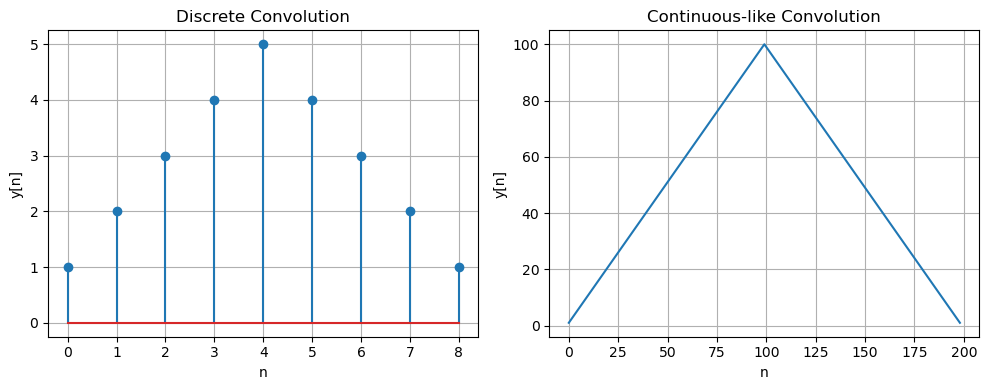

Computed values: [1. 2. 3. 4. 5. 4. 3. 2. 1.]
Expected values: [1, 2, 3, 4, 5, 4, 3, 2, 1]
Match: True


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def convolve(x, h):
    """Compute the discrete convolution of two signals x and h."""
    x = np.asarray(x)
    h = np.asarray(h)
    y_length = len(x) + len(h) - 1
    y = np.zeros(y_length)
    
    for n in range(y_length):
        for k in range(len(x)):
            if 0 <= n-k < len(h):
                y[n] += x[k] * h[n-k]
    
    return y

# Verify with rectangular signals as described in the solution
L = 5
x_rect = np.ones(L)
h_rect = np.ones(L)
y_rect = convolve(x_rect, h_rect)

# Create continuous-like signals with more samples
L_continuous = 100
x_continuous = np.ones(L_continuous)
h_continuous = np.ones(L_continuous)
y_continuous = np.convolve(x_continuous, h_continuous, mode='full')

# Plot both discrete and continuous versions in two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Discrete version
ax1.stem(range(len(y_rect)), y_rect)
ax1.set_title('Discrete Convolution')
ax1.set_xlabel('n')
ax1.set_ylabel('y[n]')
ax1.grid(True)

# Continuous version
ax2.plot(range(len(y_continuous)), y_continuous)
ax2.set_title('Continuous-like Convolution')
ax2.set_xlabel('n')
ax2.set_ylabel('y[n]')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Verify the result matches our theoretical analysis
expected_values = [i+1 if i < L else 2*L-i-1 for i in range(2*L-1)]
print(f"Computed values: {y_rect}")
print(f"Expected values: {expected_values}")
print(f"Match: {np.allclose(y_rect, expected_values)}")


### Observation

The discrete convolution matches the theoretical solution, showing a triangular shape with peak value L at n = L-1. The continuous version using numpy's convolve function also matches the theoretical solution, showing a smooth, continuous triangular shape.


### 1.2 (2 points)
If $y(n) = x(n) * h(n)$, show that $\sum_{n=-\infty}^{\infty} y(n) = (\sum_{n=-\infty}^{\infty} x(n))(\sum_{n=-\infty}^{\infty} h(n))$.

---



### 1.2 Solution

To show that $\sum_{n=-\infty}^{\infty} y(n) = (\sum_{n=-\infty}^{\infty} x(n))(\sum_{n=-\infty}^{\infty} h(n))$ where $y(n) = x(n) * h(n)$:

Starting with the definition of discrete convolution:
$y(n) = x(n) * h(n) = \sum_{k=-\infty}^{\infty} x(k)h(n-k)$

Taking the sum of $y(n)$ over all $n$:
$\sum_{n=-\infty}^{\infty} y(n) = \sum_{n=-\infty}^{\infty} \sum_{k=-\infty}^{\infty} x(k)h(n-k)$

Rearranging the order of summation:
$\sum_{n=-\infty}^{\infty} y(n) = \sum_{k=-\infty}^{\infty} x(k) \sum_{n=-\infty}^{\infty} h(n-k)$

Let's substitute $m = n-k$, then $n = m+k$. When $n$ ranges from $-\infty$ to $\infty$, $m$ also ranges from $-\infty$ to $\infty$:
$\sum_{n=-\infty}^{\infty} y(n) = \sum_{k=-\infty}^{\infty} x(k) \sum_{m=-\infty}^{\infty} h(m)$

Since $\sum_{m=-\infty}^{\infty} h(m)$ is independent of $k$, we can take it out of the summation:
$\sum_{n=-\infty}^{\infty} y(n) = \sum_{k=-\infty}^{\infty} x(k) \cdot \sum_{m=-\infty}^{\infty} h(m)$

This simplifies to:
$\sum_{n=-\infty}^{\infty} y(n) = (\sum_{k=-\infty}^{\infty} x(k))(\sum_{m=-\infty}^{\infty} h(m))$

Which is equivalent to:
$\sum_{n=-\infty}^{\infty} y(n) = (\sum_{n=-\infty}^{\infty} x(n))(\sum_{n=-\infty}^{\infty} h(n))$

Therefore, the sum of the convolution equals the product of the sums of the individual signals.



### 1.3 (4 points)
The equation for the discrete convolution of two signals is:
$$(x*h)[n] = \sum_{k=-\infty}^{\infty} x[k]h[n-k]$$
In the case of finite length signals, we assume both sides of the signal to be zero-padded. 

Compute the convolution of the following signals. As a hint, you should expect your answer to be a vector written similarly to $x(n)$ and $h(n)$, with a length one less than the sum of the length of both inputs.

1. $x(n) = [1,2,4]$, $h(n)= [1, 1, 1, 1,1]$
2. $x(n)= [1,2,-1]$, $h(n)=x(n)$

---



### 1.3 Solution

1. For $x(n) = [1,2,4]$ and $h(n)= [1, 1, 1, 1,1]$:
   
   Using the convolution formula $(x*h)[n] = \sum_{k=-\infty}^{\infty} x[k]h[n-k]$:
   
   The result will have length 3+5-1 = 7.
   
   Computing each term:
   - $(x*h)[0] = x[0]h[0] = 1 \cdot 1 = 1$
   - $(x*h)[1] = x[0]h[1] + x[1]h[0] = 1 \cdot 1 + 2 \cdot 1 = 3$
   - $(x*h)[2] = x[0]h[2] + x[1]h[1] + x[2]h[0] = 1 \cdot 1 + 2 \cdot 1 + 4 \cdot 1 = 7$
   - $(x*h)[3] = x[0]h[3] + x[1]h[2] + x[2]h[1] = 1 \cdot 1 + 2 \cdot 1 + 4 \cdot 1 = 7$
   - $(x*h)[4] = x[0]h[4] + x[1]h[3] + x[2]h[2] = 1 \cdot 1 + 2 \cdot 1 + 4 \cdot 1 = 7$
   - $(x*h)[5] = x[1]h[4] + x[2]h[3] = 2 \cdot 1 + 4 \cdot 1 = 6$
   - $(x*h)[6] = x[2]h[4] = 4 \cdot 1 = 4$
   
   Therefore, $(x*h)[n] = [1, 3, 7, 7, 7, 6, 4]$

2. For $x(n)= [1,2,-1]$ and $h(n)=x(n)$:
   
   The result will have length 3+3-1 = 5.
   
   Computing each term:
   - $(x*h)[0] = x[0]h[0] = 1 \cdot 1 = 1$
   - $(x*h)[1] = x[0]h[1] + x[1]h[0] = 1 \cdot 2 + 2 \cdot 1 = 4$
   - $(x*h)[2] = x[0]h[2] + x[1]h[1] + x[2]h[0] = 1 \cdot (-1) + 2 \cdot 2 + (-1) \cdot 1 = 2$
   - $(x*h)[3] = x[1]h[2] + x[2]h[1] = 2 \cdot (-1) + (-1) \cdot 2 = -4$
   - $(x*h)[4] = x[2]h[2] = (-1) \cdot (-1) = 1$
   
   Therefore, $(x*h)[n] = [1, 4, 2, -4, 1]$

In [18]:
# compute and verify by code
# Problem 1
x1 = np.array([1, 2, 4])
h1 = np.array([1, 1, 1, 1, 1])
conv1 = np.convolve(x1, h1, mode='full')
print("1. x(n) = [1,2,4], h(n) = [1,1,1,1,1]")
print(f"   Convolution result: {conv1}")

# Problem 2
x2 = np.array([1, 2, -1])
h2 = x2  # h(n) = x(n)
conv2 = np.convolve(x2, h2, mode='full')
print("\n2. x(n) = [1,2,-1], h(n) = x(n)")
print(f"   Convolution result: {conv2}")

# Verify our manual calculations
assert np.array_equal(conv1, np.array([1, 3, 7, 7, 7, 6, 4]))
assert np.array_equal(conv2, np.array([1, 4, 2, -4, 1]))

1. x(n) = [1,2,4], h(n) = [1,1,1,1,1]
   Convolution result: [1 3 7 7 7 6 4]

2. x(n) = [1,2,-1], h(n) = x(n)
   Convolution result: [ 1  4  2 -4  1]


### 1.4 (4 points)
Compute and plot the convolutions $x(n) * h(n)$ and $h(n) * x(n)$ for the pairs of signals shown in Figure 1.

> **Figure 1 description:**
> **Panel (a):**
>   - x(n) = [1, 1, 1, 1] (unit pulse of length 4 at n = 0, 1, 2, 3)
>   - h(n) = [6, 5, 4, 3, 2, 1, 0] (linear ramp from 6 to 0 at n = 0, 1, 2, 3, 4, 5, 6)
> 
> **Panel (b):**
>   - x(n) = [1, 1, 1, 1] (unit pulse of length 4 at n = 0, 1, 2, 3)
>   - h(n) = [6, 5, 4, 3, 2, 1, 0] (linear ramp from 6 to 0 at n = -3, -2, -1, 0, 1, 2, 3)

---

### 1.4 Solution


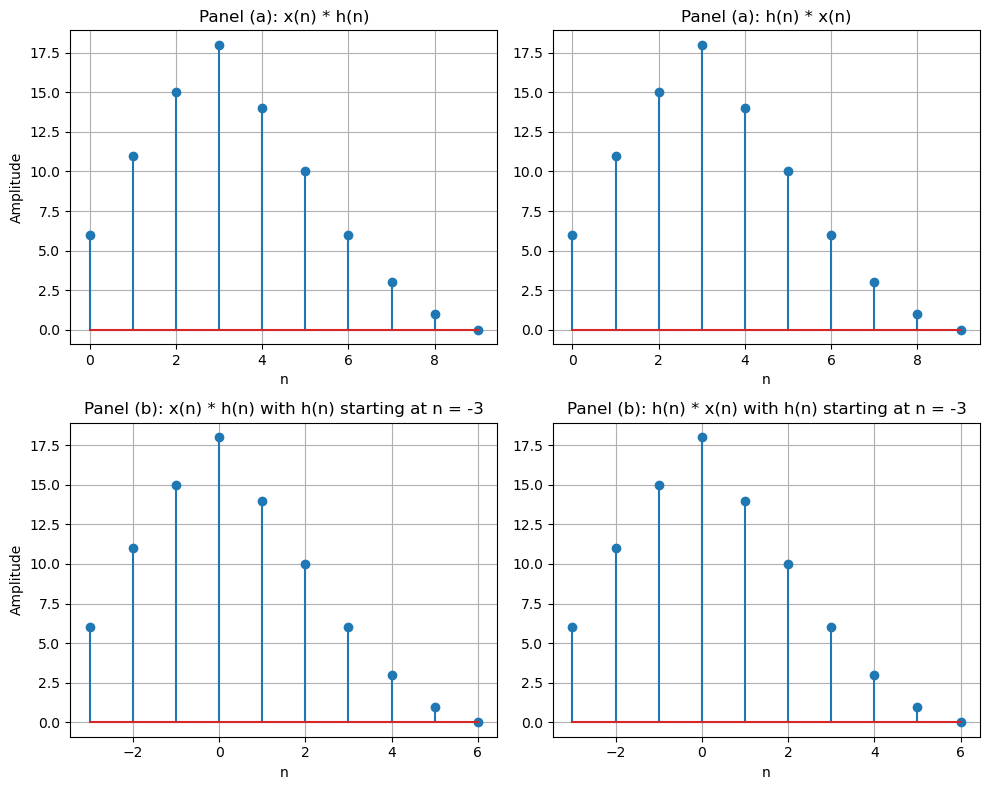

Commutative property: x(n) * h(n) = h(n) * x(n)? True


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define signals
x = np.array([1, 1, 1, 1])  # unit pulse of length 4
h_a = np.array([6, 5, 4, 3, 2, 1, 0])  # linear ramp for panel (a)

# Compute convolutions
x_conv_h = np.convolve(x, h_a, mode='full')  # x(n) * h(n)
h_conv_x = np.convolve(h_a, x, mode='full')  # h(n) * x(n)

# Create figure with 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Panel (a): h(n) starts at n=0
# Top row: x(n) * h(n)
axs[0, 0].stem(range(len(x_conv_h)), x_conv_h)
axs[0, 0].set_title('Panel (a): x(n) * h(n)')
axs[0, 0].set_xlabel('n')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].grid(True)

# Top row: h(n) * x(n)
axs[0, 1].stem(range(len(h_conv_x)), h_conv_x)
axs[0, 1].set_title('Panel (a): h(n) * x(n)')
axs[0, 1].set_xlabel('n')
axs[0, 1].grid(True)

# Panel (b): h(n) starts at n=-3
# Bottom row: x(n) * h(n)
n_indices_b = np.arange(-3, len(x_conv_h)-3)
axs[1, 0].stem(n_indices_b, x_conv_h)
axs[1, 0].set_title('Panel (b): x(n) * h(n) with h(n) starting at n = -3')
axs[1, 0].set_xlabel('n')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].grid(True)

# Bottom row: h(n) * x(n)
axs[1, 1].stem(n_indices_b, h_conv_x)
axs[1, 1].set_title('Panel (b): h(n) * x(n) with h(n) starting at n = -3')
axs[1, 1].set_xlabel('n')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Verify the commutative property
print(f"Commutative property: x(n) * h(n) = h(n) * x(n)? {np.array_equal(x_conv_h, h_conv_x)}")



## 2 Backpropagation

In binary classification, we seek to associate an input $x_n$ with its appropriate target value: $t_n = 0$ for class $C_0$ and $t_n = 1$ for class $C_1$. The cross-entropy error function is of the form:

$$E(w) = -\sum_{n=1}^{N} \{t_n \ln y_n + (1-t_n) \ln(1-y_n)\}$$

Assuming a neural network with output units which use the logistic sigmoid activation function:

$$y_n = \sigma(a_n) = \frac{1}{1+e^{-a_n}}$$

show the derivative of the above error function satisfies:

$$\frac{\partial E}{\partial a_k} = y_k - t_k$$

Hint: show that $\frac{d \sigma}{da} = \sigma(1 - \sigma)$. Use this relation to simplify the expressions for the derivatives of $\ln(y)$ and $\ln(1-y)$.

---



### 2 Solution
First, let's show that $\frac{d \sigma}{da} = \sigma(1 - \sigma)$:

$\sigma(a) = \frac{1}{1+e^{-a}}$

Taking the derivative:
$\frac{d \sigma}{da} = \frac{e^{-a}}{(1+e^{-a})^2} = \frac{1}{1+e^{-a}} \cdot \frac{e^{-a}}{1+e^{-a}} = \sigma(a) \cdot (1 - \sigma(a))$

Now, for $\frac{\partial E}{\partial a_k}$:

$E(w) = -\sum_{n=1}^{N} \{t_n \ln y_n + (1-t_n) \ln(1-y_n)\}$

For a specific output unit $k$:
$\frac{\partial E}{\partial a_k} = -\left\{t_k \frac{1}{y_k} \frac{\partial y_k}{\partial a_k} + (1-t_k) \frac{1}{1-y_k} \frac{\partial (1-y_k)}{\partial a_k}\right\}$

Since $\frac{\partial y_k}{\partial a_k} = y_k(1-y_k)$ and $\frac{\partial (1-y_k)}{\partial a_k} = -y_k(1-y_k)$:

$\frac{\partial E}{\partial a_k} = -\{t_k(1-y_k) - (1-t_k)y_k\} = -\{t_k - t_k y_k - y_k + t_k y_k\} = -\{t_k - y_k\} = y_k - t_k$

Therefore, $\frac{\partial E}{\partial a_k} = y_k - t_k$.






## 3 Jensen's Inequality

Jensen's inequality states that 
$$f(\sum_{i=1}^{M} \lambda_i x_i) \leq \sum_{i=1}^{M} \lambda_i f(x_i)$$
where $\lambda_i > 0$ and $\sum_{i} \lambda_i = 1$, for any set of points $\{x_i\}$.

Consider an $M$-state discrete random variable $x$, with entropy 
$$H(x) = -\sum_{i=1}^{M} p(x_i) \ln p(x_i)$$

Show that the entropy of its distribution $p(x)$ satisfies:
$$H(x) \leq \ln M$$

---



### 3 Solution

To prove that $H(x) \leq \ln M$, I'll use Jensen's inequality with the convex function $f(x) = -\ln(x)$.

First, note that $f(x) = -\ln(x)$ is indeed convex for $x > 0$ since its second derivative $f''(x) = \frac{1}{x^2} > 0$.

Let's define $\lambda_i = p(x_i)$ for $i = 1, 2, ..., M$. Since $p(x_i)$ is a probability distribution, we know that $p(x_i) \geq 0$ and $\sum_{i=1}^{M} p(x_i) = 1$, satisfying the conditions for Jensen's inequality.

Applying Jensen's inequality with $f(x) = -\ln(x)$:

$$f\left(\sum_{i=1}^{M} \lambda_i x_i\right) \leq \sum_{i=1}^{M} \lambda_i f(x_i)$$

Let's set $x_i = \frac{1}{p(x_i)}$ for each $i$. Then:

$$-\ln\left(\sum_{i=1}^{M} p(x_i) \cdot \frac{1}{p(x_i)}\right) \leq \sum_{i=1}^{M} p(x_i) \cdot \left(-\ln\left(\frac{1}{p(x_i)}\right)\right)$$

Simplifying the left side:
$$-\ln\left(\sum_{i=1}^{M} 1\right) = -\ln(M)$$

Simplifying the right side:
$$\sum_{i=1}^{M} p(x_i) \cdot \left(-\ln\left(\frac{1}{p(x_i)}\right)\right) = \sum_{i=1}^{M} p(x_i) \cdot \ln(p(x_i)) = -H(x)$$

Therefore:
$$-\ln(M) \leq -H(x)$$

Multiplying both sides by -1 (which reverses the inequality):
$$\ln(M) \geq H(x)$$

Thus, we have proven that $H(x) \leq \ln M$.

Note: The maximum entropy occurs when all states are equally likely, i.e., when $p(x_i) = \frac{1}{M}$ for all $i$, in which case $H(x) = \ln M$.


## 4 Infomation Theory

### 4.1 Entropy (4 points)

1. For a biased coin with probability $P(head)=p$ and $P(tail)=1-p$, show that maximal entropy is achieved when the coin is fair.

   Hint: Write the expression of binary entropy as a function of $p$ and find its maximum.

2. Plot $H(p)$ as a function of $p$, where $p$ takes values from 0 to 1.

---



### 4.1 Solution
1. The entropy of a binary random variable is defined as:

$H(p) = -p\log(p) - (1-p)\log(1-p)$

To find the maximum entropy, we take the derivative with respect to $p$ and set it to zero:

$\frac{dH(p)}{dp} = -\log(p) - 1 + \log(1-p) + 1 = \log(\frac{1-p}{p}) = 0$

This gives us $\frac{1-p}{p} = 1$, which means $1-p = p$, so $p = 0.5$

To verify this is a maximum (not a minimum), we can check the second derivative:

$\frac{d^2H(p)}{dp^2} = -\frac{1}{p} - \frac{1}{1-p} < 0$ for $0 < p < 1$

Therefore, the entropy is maximized when $p = 0.5$, i.e., when the coin is fair.

2. Here's the plot of $H(p)$ as a function of $p$:

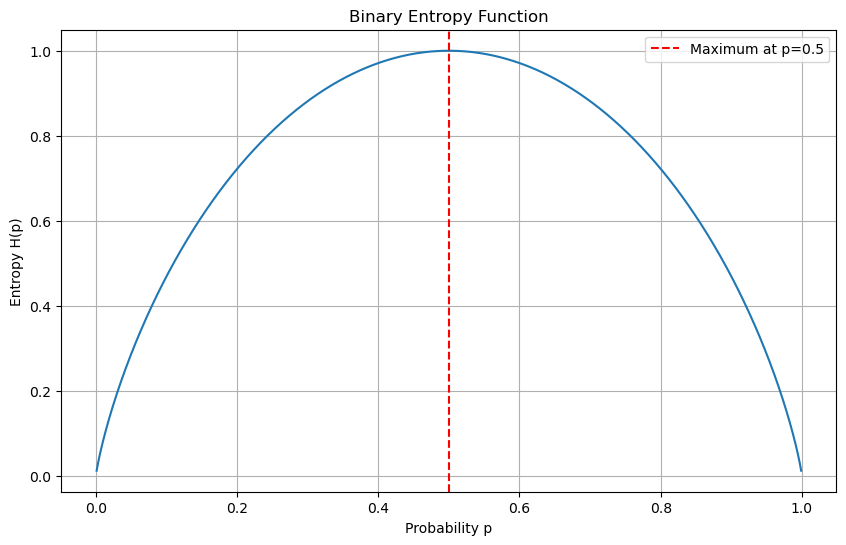

In [22]:
# Define the entropy function
def entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

# Create an array of p values from 0 to 1
p_values = np.linspace(0.001, 0.999, 1000)
entropy_values = [entropy(p) for p in p_values]

# Plot the entropy function
plt.figure(figsize=(10, 6))
plt.plot(p_values, entropy_values)
plt.axvline(x=0.5, color='r', linestyle='--', label='Maximum at p=0.5')
plt.xlabel('Probability p')
plt.ylabel('Entropy H(p)')
plt.title('Binary Entropy Function')
plt.grid(True)
plt.legend()
plt.show()


### 4.2 Mutual Information (8 points)
Assume a composer writes a melody by choosing for the first measure two notes from the 8 major scale notes spanning an octave, and for the second measure choosing the same two notes plus either the first or fifth scale degree. The purpose of the question is to consider how much information (bits) need to be sent if we already know something about how a sequence is generated, or how it may relate to another sequence (such as its own past)

1. If we treat the composer as an information source, and we know that they always use the above method for writing their melodies, how many bits are required to represent the first bar?

   Hint: Determine how many bits are required to represent initially the alphabet (the total number of possible notes in octave), which gives you # of bits per note without any prior information or compressions.

2. How many bits are required to represent the second bar?

   Hint: Consider the number of bits you need when you use the prior information from the first bar to encode the second bar.

3. If we represent the first bar as random variable $X$ and the second bar as random variable $Y$, write the expressions for $H(X)$, $H(Y)$, and $H(Y|X)$.

4. What is the mutual information $I(X,Y)$ between the first and second bar? Hint: Think about how many bits of information are already contained in $X$ in order to compose $Y$.

---



**Setup:**  
- We have an 8‐note major scale (an alphabet of size 8).  
- **First measure (bar)**: 2 notes chosen freely from the 8.  
- **Second measure**: the *same* 2 notes from the first bar, plus **either** the 1st or the 5th scale degree (i.e., only 2 possible extra notes).



### 1. Bits Required to Represent the First Bar

- Each note is chosen from 8 possibilities, requiring $\log_2(8) = 3$ bits per note.  
- Because the first bar has 2 notes:
  $$
  H(X) \;=\; 2 \times 3 \;=\; 6\ \text{bits}.
  $$

Hence, **6 bits** are needed to encode the first measure with no prior information.



### 2. Bits Required to Represent the Second Bar

- Once the first bar $X$ is known, we already know which 2 notes are used in the second bar.
- The only “new” information is which extra note (the 1st or 5th scale degree) is added.  
- There are 2 possibilities, so
  $$
  \text{Information for the second bar given the first} = \log_2(2) = 1\ \text{bit}.
  $$
  
Hence, **1 bit** is needed to encode the second bar given the first bar.



### 3. Entropy Expressions

Let $X$ = “first bar,” $Y$ = “second bar.” Then:

- $\displaystyle H(X)$: the entropy of the first bar.  We’ve seen that $X$ consists of 2 notes from 8 possibilities each:
  $$
  H(X) \;=\; \log_2\bigl(8^2\bigr) \;=\; 6 \text{ bits}.
  $$
- $\displaystyle H(Y)$: the entropy of the second bar *if viewed in isolation.*  
  - The second bar has 3 notes. However, it is constrained so that the first 2 notes match *some* pair from 8×8 possibilities, and the 3rd note is one of 2 possibilities. Hence the total number of possible second bars is $8 \times 8 \times 2 = 128$.  
  - So $\displaystyle H(Y) = \log_2(128) = 7\ \text{bits}.$
- $\displaystyle H(Y\mid X)$: the conditional entropy of the second bar given the first bar.  
  - Given $X$, the 2 notes in $Y$ are fixed, and only the choice between scale degree 1 or 5 remains:
    $$
    H(Y\mid X) \;=\; \log_2(2) \;=\; 1\ \text{bit}.
    $$



### 4. Mutual Information $I(X;Y)$

By definition,  
$$
I(X;Y) \;=\; H(Y) - H(Y\mid X).
$$
From the above:

$$
H(Y) = 7\ \text{bits}, 
\quad 
H(Y\mid X) = 1\ \text{bit},
$$
so

$$
\boxed{
I(X;Y) = 7 - 1 = 6\ \text{bits}.
}
$$

**Interpretation:** Knowing $X$ “saves” you 6 bits of description about $Y$, leaving only 1 bit of genuine “new” information (whether the composer added the 1st or 5th scale degree).

## 5 ELBO

### 5.1 Latent Variables (10 points)

1. The basic idea in the Variational Method and Expectation-Maximization is to maximize the ELBO instead of likelihood $P(X|\theta)$. With this "trick", we can find the optimal model shown in Class. For this problem we provide a slightly different formulation, where the expectation $E$ is done over $q(Z)$ instead of $q(Z|x)$. Both versions of ELBO are used in practice, depending on whether the objective is to construct an encoder $Q$ that is more sensitive to input $X$ or not.

    Prove that the log likelihood in $p(X|\theta)$ can be decomposed as $ELBO + KL(q||p)$, where

    \begin{align*}
    \text{ELBO} = \mathcal{L}(q,\theta)&=\sum_z q(Z)\ln \frac{p(x,Z|\theta)}{q(Z)}\\
    & \text{and} \\
    \text{KL}(q||p)&=-\sum_z q(Z)\ln \frac{p(Z|x,\theta)}{q(Z)}
    \end{align*}

    with $q$ representing the distribution of the latent variables $Z$ and $KL(q||p)$ representing the Kullback-Leibler divergence between the distributions $q$ and $p$.

    Hint: Use definitions of conditional probability (Bayes' rule) so that the sum of the ELBO and KL expressions cancel the dependency of the probability on the variable $Z$.

2. ELBO and EM are closely related. One is approximating the likelihood using VAE through differentiable programming (i.e. gradient descent), and the other is an iterative solution. While VAE uses gradient descent to find the approximate distribution $q$, the EM method uses an old estimate of $p(x|z, \theta)$ as the approximation.

    In the EM algorithm, the expectation of the complete-data log likelihood evaluated for some general parameter value $\theta$ is given as

    $$Q(\theta,\theta^{old}) = \sum_Z p(Z|X,\theta^{old})\ln p(X,Z|\theta)$$

    where $p(Z|X, \theta^{old})$ is the posterior distribution of the latent variables estimated in the E step using the current parameter values $\theta^{old}$. Show that the ELBO is the same as $Q(\theta, \theta^{old})$, up to an entropy term in $q$ for $q=p(z|x,\theta)$.

    Hint: entropy is defined as $\sum q\ln q$.

3. Argue that the best approximate distribution $q$ for a given parameter $\theta$ is the posterior distribution $p(Z|X, \theta)$, and use this argument to explain the purpose of the E step in the EM algorithm.

4. Show that maximizing the ELBO is equivalent to maximizing $Q(\theta, \theta_{old})$. Hint: verify which part of the equation depends on the model parameter $\theta$.

---



We have a latent variable model with observed variable $X$, latent variable $Z$, and parameters $\theta$. The *variational approach* posits an auxiliary distribution $q(Z)$ over $Z$ to approximate the true posterior $p(Z \mid X,\theta)$. We’ll show how the log-likelihood $\ln p(X\mid \theta)$ can be decomposed into the **ELBO** (Evidence Lower BOund) plus a **KL divergence** term between $q$ and the true posterior.



### **1. The Decomposition: $\ln p(X|\theta)$ = ELBO + KL**

We want to prove that

$$
\ln p(X \mid \theta)
\;=\;
\underbrace{\sum_{z} q(Z)\,\ln\frac{p(X,Z\mid \theta)}{q(Z)}}_{\text{ELBO}}
\;+\;
\underbrace{\bigl[-\sum_{z} q(Z)\,\ln \tfrac{p(Z\mid X,\theta)}{q(Z)}\bigr]}_{\text{KL divergence}},
$$
or more succinctly,
$$
\ln p(X\mid \theta)
\;=\;
\mathcal{L}(q,\theta) + \mathrm{KL}\bigl(q \;\|\; p \bigr).
$$

1. Write $\ln p(X \mid \theta)$ as a sum over $Z$

    Since
    $$
    p(X\mid \theta)
    \;=\;
    \sum_{z} p(X,Z \mid \theta),
    $$
    we have
    $$
    \ln p(X\mid \theta)
    \;=\;
    \ln \sum_{z} p(X,Z \mid \theta).
    $$

2. Multiply and Divide by $q(Z)$

    Insert an arbitrary distribution $q(Z)$ inside the sum:

    $$
    p(X,Z\mid \theta)
    \;=\;
    \frac{p(X,Z\mid \theta)}{q(Z)} \, q(Z).
    $$

    Hence,

    $$
    \ln p(X\mid \theta)
    = \ln \sum_{z} q(Z)\,\frac{p(X,Z\mid \theta)}{q(Z)}.
    $$

3. Apply Jensen’s Inequality

    Define $\displaystyle \mathbb{E}_{q(Z)}[\cdot] = \sum_{z} q(Z)\,[\cdot]$. Recognize that we have a log of an expectation:

    $$
    \ln p(X\mid \theta)
    = 
    \ln \mathbb{E}_{Z\sim q}\Bigl[\frac{p(X,Z\mid \theta)}{q(Z)}\Bigr].
    $$

    By Jensen’s inequality (using $\ln(\mathbb{E}[X]) \ge \mathbb{E}[\ln X]$), we get

    $$
    \ln p(X\mid \theta)
    \;\ge\;
    \sum_{z} q(Z)\,\ln \frac{p(X,Z\mid \theta)}{q(Z)}
    \;=:\;
    \mathcal{L}(q,\theta),
    $$

    which is the **ELBO** (Evidence Lower BOund).

4. Rearrange and Identify KL Divergence

    Finally, consider the *difference* between $\ln p(X\mid \theta)$ and $\mathcal{L}(q,\theta)$. By expanding $\ln p(X,Z\mid \theta) = \ln p(X\mid \theta) + \ln p(Z\mid X,\theta)$ and grouping terms, one finds:

    $$
    \ln p(X\mid \theta)
    \;-\;
    \sum_{z} q(Z)\,\ln \frac{p(X,Z\mid \theta)}{q(Z)}
    \;=\;
    \sum_{z} q(Z)\,\ln \frac{q(Z)}{p(Z\mid X,\theta)}.
    $$

    The right-hand side is exactly the definition of the Kullback–Leibler divergence:

    $$
    \mathrm{KL}\bigl(q(Z)\,\|\,p(Z\mid X,\theta)\bigr)
    = \sum_{z} q(Z)\,\ln \frac{q(Z)}{p(Z\mid X,\theta)}.
    $$

Hence,

$$
\ln p(X\mid \theta)
= 
\underbrace{\sum_{z} q(Z)\,\ln \frac{p(X,Z\mid \theta)}{q(Z)}}_{\text{ELBO}}
\;+\;
\underbrace{\mathrm{KL}\bigl(q(Z)\,\|\,p(Z\mid X,\theta)\bigr)}_{\ge0}.
$$

Thus we obtain the **ELBO + KL** decomposition:

$$
\boxed{
\ln p(X\mid \theta)
=
\mathcal{L}(q,\theta)
+
\mathrm{KL}\bigl(q(Z)\,\|\,p(Z\mid X,\theta)\bigr).
}
$$

Since KL divergence is always non-negative, this shows $\mathcal{L}(q,\theta)$ is indeed a **lower bound** on $\ln p(X\mid \theta)$.



### **2. Relation to EM and the Function $Q(\theta,\theta^{old})$**

#### **EM’s $Q(\theta,\theta^{old})$ expression**  
In the EM algorithm, for a current parameter estimate $\theta^{old}$, the *E step* computes the posterior $p(Z\mid X,\theta^{old})$, and then one defines
$$
Q(\theta,\theta^{old})
\;=\;
\sum_{Z} p(Z \mid X,\theta^{old})\,\ln p(X,Z \mid \theta).
$$

Let’s compare this to the ELBO in the special case that $q(Z)=p(Z\mid X,\theta^{old})$. Then the ELBO is
$$
\mathcal{L}(q,\theta)
\;=\;
\sum_{Z} p(Z \mid X,\theta^{old})\,\ln \frac{p(X,Z\mid \theta)}{p(Z\mid X,\theta^{old})}.
$$
Observe that
$$
\mathcal{L}(q,\theta)
\;=\;
\sum_{Z} p(Z\mid X,\theta^{old})\,\ln p(X,Z\mid \theta)
\;-\;
\sum_{Z} p(Z\mid X,\theta^{old})\,\ln p(Z\mid X,\theta^{old}).
$$
The second term
$\displaystyle -\sum_{Z} p(Z\mid X,\theta^{old})\ln p(Z\mid X,\theta^{old})$
is the *entropy* of the distribution $p(Z\mid X,\theta^{old})$. Hence:

$$
\boxed{
\mathcal{L}(p(Z\mid X,\theta^{old}),\,\theta)
\;=\;
Q(\theta,\theta^{old})
\;-\;
H\bigl(p(Z\mid X,\theta^{old})\bigr).
}
$$

So **ELBO** differs from **$Q$-function** by an additive constant $-H\bigl(p(Z\mid X,\theta^{old})\bigr)$ (which does not depend on $\theta$). Hence maximizing $\mathcal{L}$ w.r.t. $\theta$ is equivalent to maximizing $Q(\theta,\theta^{old})$.  



### **3. Best Approximate Distribution $q$**

From the decomposition
$$
\ln p(X\mid \theta)
= \underbrace{\sum_z q(Z)\,\ln \tfrac{p(X,Z\mid \theta)}{q(Z)}}_{\mathcal{L}(q,\theta)}
+ \mathrm{KL}\bigl(q(Z)\,\|\,p(Z\mid X,\theta)\bigr),
$$
note that $\ln p(X\mid \theta)$ does **not** depend on $q$. Therefore, minimizing the KL divergence term $\mathrm{KL}(q \;\|\; p(Z\mid X,\theta))$ w.r.t. $q$ is achieved precisely when
$$
q(Z) = p(Z\mid X,\theta).
$$
Thus, **the “best” approximate distribution** under this framework is the true posterior.

**Interpretation in EM:**  
- The E‐step effectively sets $q(Z) = p(Z\mid X,\theta^{\text{old}})$.  
- This ensures we’re using the posterior over $Z$ given the most recent parameter estimate $\theta^{\text{old}}$.  

That is exactly how EM updates the distribution of latent variables: in the E-step, we compute or approximate the posterior with the current parameters.



### **4. Maximizing ELBO $\iff$ Maximizing $Q(\theta,\theta^{old})$**

Recall that
$$
\mathcal{L}(p(Z\mid X,\theta^{\text{old}}),\theta)
\;=\;
Q(\theta,\theta^{\text{old}}) - H\bigl(p(Z\mid X,\theta^{\text{old}})\bigr).
$$
Because the **entropy** term $H\bigl(p(Z\mid X,\theta^{\text{old}})\bigr)$ does **not** depend on the new parameters $\theta$, the objective $\mathcal{L}$ and $Q(\theta,\theta^{\text{old}})$ differ by a $\theta$-independent constant. Therefore, maximizing the ELBO w.r.t. $\theta$ is the same as maximizing $Q(\theta,\theta^{\text{old}})$.

**Conclusion:** Once $q(Z)=p(Z\mid X,\theta^{\text{old}})$ is chosen, any parameter $\theta$ that increases $\mathcal{L}(q,\theta)$ equivalently increases $Q(\theta,\theta^{\text{old}})$. Hence the M-step is exactly maximizing $\mathcal{L}$ or $Q$.



## **Summary of Answers**

1. **ELBO + KL Decomposition**  
   $$
   \ln p(X \mid \theta)
   \;=\;
   \underbrace{\sum_z q(Z)\,\ln\tfrac{p(X,Z \mid \theta)}{q(Z)}}_{\text{ELBO}}
   \;+\;
   \underbrace{\mathrm{KL}\bigl(q(Z)\,\|\,p(Z\mid X,\theta)\bigr)}_{\ge 0}.
   $$
   
2. **Relation to EM’s $Q(\theta,\theta^{old})$**  
   For $q(Z) = p(Z\mid X,\theta^{\text{old}})$,
   $$
   \mathcal{L}(q,\theta)
   \;=\;
   Q(\theta,\theta^{\text{old}})\;-\;H\!\bigl(p(Z\mid X,\theta^{\text{old}})\bigr).
   $$

3. **Best $q$ is the posterior**  
   Minimizing $\mathrm{KL}(q \|\; p(Z\mid X,\theta))$ forces $q(Z) = p(Z\mid X,\theta)$. EM’s E-step uses the old parameters to obtain the posterior over $Z$.

4. **Maximizing ELBO $\iff$ Maximizing $Q(\theta,\theta^{old})$**  
   Because they differ only by a $\theta$-independent entropy constant, improving $\theta$ to maximize the ELBO also maximizes $Q(\theta,\theta^{old})$.

Thus, the EM algorithm can be viewed as an alternating maximization of the ELBO: first pick $q=p(Z\mid X,\theta^{\text{old}})$ (E-step), then maximize over $\theta$ (M-step).

## 6 Gaussian Approximation (4 points)

Suppose that $p(x)$ is some fixed distribution and that we wish to approximate it using a Gaussian distribution $g(x)=N(x|\mu, \Sigma)$. By writing down the form of the KL divergence $KL(p||g)$ for a Gaussian $g(x)$ and then differentiating, show that minimization of $KL(p||g)$ with respect to $\mu$ and $\Sigma$ leads to the result that $\mu$ is given by the expectation of $x$ under $p(x)$ and that $\Sigma$ is given by the covariance.

---



### **1. Express the KL Divergence $\mathrm{KL}(p\|g)$**

The KL divergence between $p$ and $g$ is
$$
\mathrm{KL}(p\|g)
\;=\;
\int p(x) \,\ln \frac{p(x)}{g(x)}\,dx
\;=\;
\int p(x)\,\ln p(x)\,dx \;-\; \int p(x)\,\ln g(x)\,dx.
$$
Since $\int p(x)\,\ln p(x)\,dx$ does **not** depend on $\mu$ or $\Sigma$, minimizing $\mathrm{KL}(p\|g)$ is equivalent to **maximizing** the second term $\int p(x)\ln g(x)\,dx$, or equivalently **minimizing** the negative of that term.  

So we focus on the part:
$$
-\int p(x)\,\ln g(x)\,dx.
$$

### **2. Write Down $\ln g(x)$ for the Gaussian**

A multivariate Gaussian with mean $\mu$ and covariance $\Sigma$ has density
$$
g(x)
=
\frac{1}{\sqrt{(2\pi)^D \,\det(\Sigma)}} \exp\!\Bigl[-\tfrac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)\Bigr].
$$
Hence,
$$
\ln g(x)
\;=\;
-\frac{D}{2}\,\ln(2\pi)
-\frac{1}{2}\ln \det(\Sigma)
-\frac{1}{2}\,(x - \mu)^\top \Sigma^{-1} (x - \mu),
$$
where $D$ is the dimension of $x$.

Therefore,
$$
-\int p(x)\,\ln g(x)\,dx
=
\int p(x)\,\biggl[
  \frac{D}{2}\,\ln(2\pi)
  +\tfrac{1}{2}\ln \det(\Sigma)
  +\tfrac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)
\biggr]\,dx.
$$
We can factor out constant terms, etc.

### **3. Differentiate w.r.t. $\mu$ and $\Sigma$**

#### 3.1 **Minimize w.r.t. $\mu$**

Focus on the part that depends on $\mu$:
$$
\frac{1}{2} \int p(x)\,(x-\mu)^\top \Sigma^{-1} (x - \mu)\,dx.
$$
We can rewrite $(x - \mu)^\top \Sigma^{-1}(x - \mu)$ as $\mathrm{tr}\bigl[\Sigma^{-1}(x - \mu)(x - \mu)^\top\bigr]$. For convenience, think of the derivative in simpler scalar forms:

- Set derivative w.r.t. $\mu$ to zero.
- Expand:
  $$
  (x - \mu)^\top \Sigma^{-1}(x - \mu)
  = \mathrm{const} - 2\,(\Sigma^{-1}x)^\top \mu + \mu^\top\Sigma^{-1}\mu.
  $$

Hence, if we define
$$
\mathcal{L}(\mu,\Sigma)
\;=\;
\int p(x)\,\bigl[(x-\mu)^\top \Sigma^{-1}(x-\mu)\bigr]\,dx,
$$
then differentiating w.r.t. $\mu$ (treating $\Sigma^{-1}$ as constant for this partial derivative) yields:
$$
\frac{\partial \mathcal{L}}{\partial \mu}
=
-2\,\Sigma^{-1}\,\int p(x)\,x\,dx
\;+\;
2\,\Sigma^{-1}\,\mu\,\int p(x)\,dx
=
-2\,\Sigma^{-1}\,\mathbb{E}_p[x]
+ 2\,\Sigma^{-1}\,\mu.
$$
Setting this equal to zero implies
$$
\Sigma^{-1}\,\mu = \Sigma^{-1}\,\mathbb{E}_p[x]
\quad \Longrightarrow \quad
\mu = \mathbb{E}_p[x].
$$

Thus the optimal $\mu$ is the **mean** of $x$ under $p$.

#### 3.2 **Minimize w.r.t. $\Sigma$**

Now set $\mu = \mathbb{E}_p[x]$ and handle the terms involving $\Sigma$. We have two pieces that depend on $\Sigma$ in the negative log-likelihood portion:

1. $\tfrac{1}{2}\,\ln \det(\Sigma)$  
2. $\tfrac{1}{2}\,\int p(x)\,(x - \mu)^\top \Sigma^{-1} (x - \mu)\,dx$

Hence, the relevant function of $\Sigma$ to minimize is (omitting constants):
$$
\mathcal{F}(\Sigma)
=
\frac{1}{2}\ln \det(\Sigma)
\;+\;
\frac{1}{2}
\int p(x)\,(x - \mu)^\top \Sigma^{-1} (x - \mu)\,dx.
$$
Let’s denote $S = \mathbb{E}_p[(x - \mu)(x - \mu)^\top]$, the covariance of $p$. Then
$$
\mathcal{F}(\Sigma)
=
\frac{1}{2}\,\ln \det(\Sigma)
+ \frac{1}{2}\,\mathrm{tr}\!\bigl[\Sigma^{-1} S\bigr].
$$

Taking the derivative w.r.t. $\Sigma^{-1}$ is standard in matrix calculus. The known results are:

- $\frac{\partial}{\partial \Sigma^{-1}} \ln \det(\Sigma) = -(\Sigma)^\top = -\Sigma$ (since $\Sigma$ is symmetric).
- $\frac{\partial}{\partial \Sigma^{-1}} \,\mathrm{tr}(\Sigma^{-1} S) = -S^\top = -S$ (also using the symmetry of $S$).

Hence,
$$
\frac{\partial \mathcal{F}(\Sigma)}{\partial \Sigma^{-1}}
=
-\tfrac{1}{2}\,\Sigma + \tfrac{1}{2}\,S.
$$
Setting this to zero gives
$$
\Sigma = S = \mathbb{E}_p\bigl[(x - \mu)(x - \mu)^\top\bigr].
$$

Thus $\Sigma$ must be the **covariance** of $p$.

### **4. Conclusion**

**By minimizing** $\mathrm{KL}\bigl(p(x)\,\|\,\mathcal{N}(x\mid \mu, \Sigma)\bigr)$ with respect to $\mu$ and $\Sigma$, we get:
$$
\boxed{
\mu = \mathbb{E}_p[x],
\quad
\Sigma = \mathbb{E}_p\bigl[(x - \mu)(x - \mu)^\top\bigr].
}
$$
That is, we match the mean and covariance of the Gaussian to the mean and covariance of $p$.

This completes the proof.

## 7 Probabilistic PCA

In probabilistic PCA, the observations are assumed to be generated from latent variable $z$ with added noise $\epsilon$ according to
   $$x = Wz + \mu + \epsilon$$
   
1. Using expressions for the mean and covariance of $x$, prove that
   $$E[x] = \mu$$
   
   and
   $$\text{cov}[x] = WW^T + \sigma$$
   
   In your explanation, use the assumption that
   $$z \sim \mathcal{N}(\mathbf{0}, I)$$
   
   Explain where you use this assumption.

2. It can be shown that:
   $$p(z|x) = \mathcal{N}(z|M^{-1}W^T(x-\mu), M^{-1}\sigma^{-2})$$
   
   where $M$ is defined as
   $$M = W^TW + \sigma^2I$$
   
   Show that as $\sigma \to 0$, the posterior mean for $z$ given $x$ becomes
   $$E(z|x) = (W^TW)^{-1}W^T(x-\mu)$$

3. In non-probabilistic (regular) PCA, the goal is to approximate a vector $x$ that has $D$ dimensions by combination from a smaller set of basis vectors $w_1, w_2,...w_M$ with $M < D$. Arranging the basis vectors as columns of a matrix $W$, consider $\hat{x} = Wz$ to be a low dimensional approximation to $x$. Explain why $z$ is $M$-dimensional, and show that for a fixed $W$, the optimal $z$ is found by the pseudo-inverse of $W$ given by
   $$(W^TW)^{-1}W^T$$
   
   Compare this to the maximum likelihood result for probabilistic PCA, and describe your observation.
   
   Hint: to find a pseudo-inverse, write $x = Wz + \text{error}$. Then, write an expression for MSE and minimize with respect to $z$, showing that optimal $z$ is given by $(W^TW)^{-1}W^Tx$.

---



### **1. Mean and Covariance of $x$**

We want to prove:

1. $E[x] = \mu$.
2. $\mathrm{cov}[x] = W\,W^\top + \sigma^2 I.$

#### **1.1 Compute $E[x]$**

By definition,
$$
x = Wz + \mu + \epsilon.
$$
Taking the expectation:

$$
\begin{aligned}
\mathbb{E}[x]
&= \mathbb{E}[Wz] + \mathbb{E}[\mu] + \mathbb{E}[\epsilon]\\
&= W\,\mathbb{E}[z] + \mu + \mathbb{E}[\epsilon].
\end{aligned}
$$
We know:
- $z \sim \mathcal{N}(0,I)$ implies $\mathbb{E}[z] = 0$.
- $\mu$ is a constant vector, so $\mathbb{E}[\mu]=\mu$.

We used the assumption $z\sim \mathcal{N}(0,I)$ to conclude $\mathbb{E}[z]=0$. Why did we assume so?  
- We assume $z$ is zero-mean and identity-covariance so that all variance structure in the observed data arises from $W$ and the noise covariance $\sigma^2 I$.
- Mathematically, it makes the derivation neat and yields closed-form solutions for the posterior and MLE updates.
- Conceptually, it aligns perfectly with the interpretation of PCA as finding orthonormal directions of maximal variance, captured in $W$.

Hence, and by another hidden assumption that $\epsilon \sim \mathcal{N}(0, \sigma^2 I)$:

$$
\mathbb{E}[x]
= W \cdot 0 + \mu + 0
= \mu.
$$

#### **1.2 Compute $\mathrm{cov}[x]$**

Next, we write:

$$
\mathrm{cov}[x]
= \mathbb{E}\bigl[(x - \mathbb{E}[x])(x - \mathbb{E}[x])^\top\bigr].
$$
Since $\mathbb{E}[x]=\mu$, we have
$$
x - \mu
= (Wz + \mu + \epsilon) - \mu
= Wz + \epsilon.
$$
Thus,

$$
\mathrm{cov}[x]
= \mathbb{E}\Bigl[(Wz + \epsilon)\,(Wz + \epsilon)^\top\Bigr]
= \mathbb{E}\bigl[ Wz\,z^\top W^\top \bigr] + \mathbb{E}\bigl[\epsilon\,\epsilon^\top\bigr]
+ \mathbb{E}\bigl[Wz\,\epsilon^\top\bigr] + \mathbb{E}\bigl[\epsilon\,z^\top W^\top\bigr].
$$

Because $z$ and $\epsilon$ are assumed **independent** (that’s part of the generative model assumption), we get
$$
\mathbb{E}[Wz \,\epsilon^\top] = W\,\mathbb{E}[z]\,\mathbb{E}[\epsilon]^\top = 0,
$$
and similarly $\epsilon\,z^\top=0$. Therefore,

$$
\mathrm{cov}[x]
= W\,\mathbb{E}[z\,z^\top]\,W^\top + \mathbb{E}[\epsilon \,\epsilon^\top].
$$
Given $z\sim \mathcal{N}(0,I)$, we have $\mathbb{E}[z\,z^\top] = I$. Also, $\epsilon \sim \mathcal{N}(0, \sigma^2 I)$ implies $\mathbb{E}[\epsilon\,\epsilon^\top] = \sigma^2 I$. Hence,

$$
\mathrm{cov}[x]
= W\,I\,W^\top + \sigma^2 I
= W\,W^\top + \sigma^2 I.
$$



### **2. Posterior of $z$ Given $x$**

It is known that:
$$
p(z \mid x)
= \mathcal{N}\!\Bigl(z \mid M^{-1}W^\top (x-\mu),\ M^{-1}\,\sigma^{-2} \Bigr),
$$
where
$$
M = W^\top W + \sigma^2 I.
$$

We want to show that as $\sigma\to0$, the posterior mean
$$
\mathbb{E}[z \mid x]
= M^{-1}W^\top(x-\mu)
$$
reduces to
$$
(W^\top W)^{-1} \,W^\top\,(x-\mu).
$$

#### **2.1 As $\sigma\to 0$**

Recall
$$
M = W^\top W + \sigma^2 I
\quad\Longrightarrow\quad
M^{-1}
= \bigl(W^\top W + \sigma^2 I\bigr)^{-1}.
$$
When $\sigma$ is very small, $\sigma^2 I\approx 0$. Hence in the limit $\sigma\to 0$,

$$
M^{-1}
\;\to\;
(W^\top W)^{-1}.
$$
Thus,
$$
\mathbb{E}[z\mid x]
= M^{-1}\,W^\top\,(x-\mu)
\;\to\;
(W^\top W)^{-1} W^\top\,(x-\mu).
$$

Hence, the posterior mean becomes precisely the *least‐squares solution* for $z$, consistent with classical PCA.



### **3. Connection to Non-Probabilistic (Classical) PCA**

In **non-probabilistic PCA**, we think:  
1. $x \in \mathbb{R}^D$ is approximated by $\hat{x} = Wz$ where $W \in \mathbb{R}^{D\times M}$.  
2. Because we want a “low dimensional” representation, we have $M < D$. So $z\in\mathbb{R}^M$.

#### **3.1 Why is $z$ $M$-dimensional?**

- We choose $M$ basis vectors $\{w_1, w_2, \ldots, w_M\}$. Each $w_i \in \mathbb{R}^D$.  
- Arranging these as columns in $W$ gives a $D \times M$ matrix.  
- If we want a linear combination $Wz = \sum_{i=1}^M z_i\,w_i$, then $z$ must have $M$ components.

Hence dimension of $z$ is exactly the number of columns in $W$.

#### **3.2 Optimal $z$ for Fixed $W$**

Given a data vector $x$, the classical PCA approximation is

$$
x \approx Wz \quad\Longrightarrow\quad \text{error} = x - Wz.
$$
We define a mean-square error (MSE) objective:

$$
\| x - Wz \|^2,
$$
and want to pick $z$ that **minimizes** this quantity, for a **fixed** $W$. Hence,

$$
\min_z \bigl\| x - Wz\bigr\|^2
= \min_z \bigl(x - Wz\bigr)^\top\bigl(x - Wz\bigr).
$$
To find the optimum, **set derivative to zero**:

$$
\frac{\partial}{\partial z}
\bigl[(x - Wz)^\top(x - Wz)\bigr]
=
-2\,W^\top\,(x - Wz) = 0.
$$
Solving,

$$
W^\top x - W^\top W z = 0
\quad\Longrightarrow\quad
W^\top W\,z = W^\top x
\quad\Longrightarrow\quad
z = (W^\top W)^{-1} W^\top x,
$$
assuming $W^\top W$ is invertible (i.e. $W$ has full column rank).

Thus the **pseudo-inverse** of $W$ is $(W^\top W)^{-1} W^\top$.

#### **3.3 Compare to Probabilistic PCA**

From **Section 2**, the **posterior mean** for the latent variable $z$ given $x$ (in the noise-free limit $\sigma\to 0$) is:

$$
\mathbb{E}[z\mid x] = (W^\top W)^{-1}W^\top \,(x-\mu).
$$
Hence in the probabilistic PCA framework, once we subtract the mean $\mu$, we get the same formula as the classical PCA pseudo-inverse solution.

**Observation:**  
- Probabilistic PCA can be seen as a probabilistic version of the classical approach.  
- In the limit of zero noise $\sigma\to0$, the posterior mean of $z$ coincides with the least squares solution $\hat{z}$ from classical PCA.  
- However, in the **probabilistic** version, we also get a full posterior **distribution** $p(z\mid x)$, not just a point estimate.  



### **Summary of Answers**

1. **Mean and Covariance** of $x$:
   $$
   \mathbb{E}[x]=\mu
   \quad\text{and}\quad
   \mathrm{cov}[x]=W\,W^\top+\sigma^2 I,
   $$
   using the assumptions $z\sim \mathcal{N}(0,I)$ and $\epsilon\sim \mathcal{N}(0,\sigma^2I)$.

2. **Posterior Mean**: $p(z\mid x)$ is Gaussian with
   $$
   \mathbb{E}[z\mid x] = (W^\top W + \sigma^2I)^{-1}\,W^\top\,\bigl(x-\mu\bigr).
   $$
   As $\sigma\to0$,
   $$
   \mathbb{E}[z\mid x]\;\to\;(W^\top W)^{-1}\,W^\top\,(x-\mu).
   $$

3. **Connection to Classical PCA**:
   - In non-probabilistic PCA, we minimize $\| x - Wz\|^2$.  
   - The optimal $z$ w.r.t. MSE is $(W^\top W)^{-1}W^\top x$.  
   - This matches the **noise-free** ($\sigma=0$) posterior mean solution in probabilistic PCA.  

Hence, **probabilistic PCA** generalizes classical PCA by placing a Gaussian prior on $z$ and adding Gaussian noise $\epsilon$. The EM algorithm or direct maximum-likelihood in the probabilistic framework yields the same principal subspace solutions, but also a richer interpretation in terms of latent-variable distributions.

# DKU Assignment 1

### PCA with Linear Autoencoder

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 




In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.stats import truncnorm

# PCA with a Linear Autoencoder

In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in pyTorch. 

Let's create a sin+noise signal to use as input to our network:

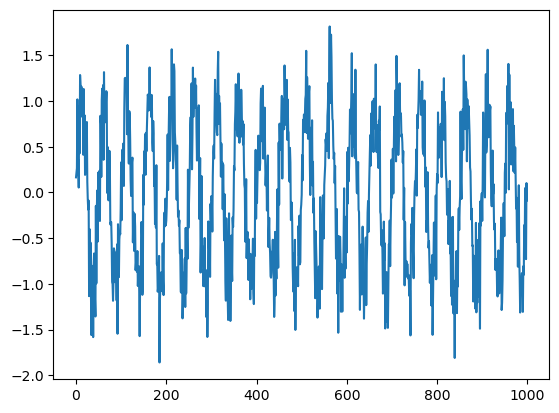

In [27]:
f0 = 200
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n 

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers. 

This neural network is implemented in pyTorch. 

Please review the code cells below, and answer the questions that follow. 

In [28]:
n_inputs = np.shape(xmat)[0]
n_hidden = 2 
learning_rate = 0.01 

W=Variable(torch.normal(0, 0.1, (400,2)), requires_grad=True)

optimizer=torch.optim.Adam([W],lr=learning_rate)

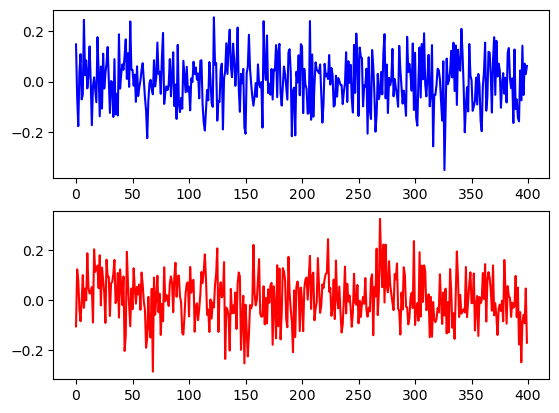

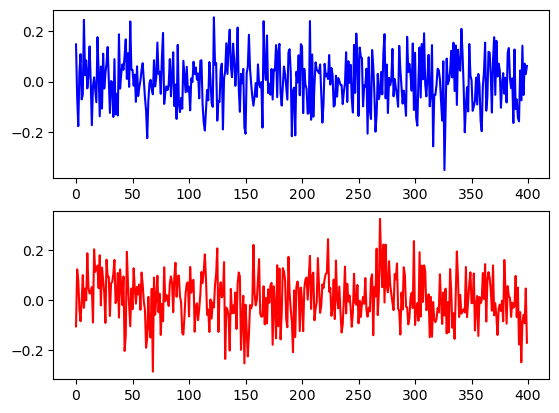

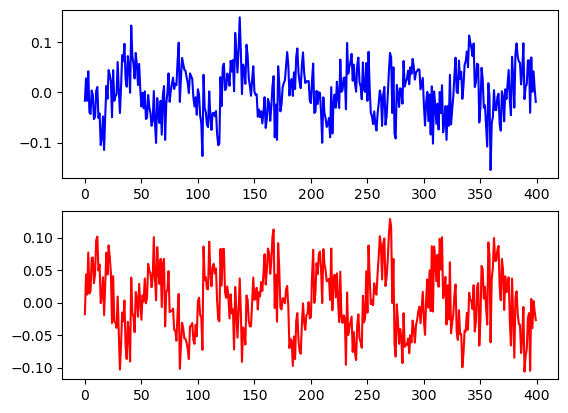

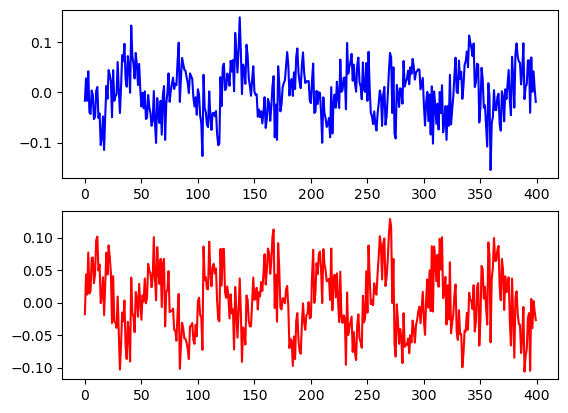

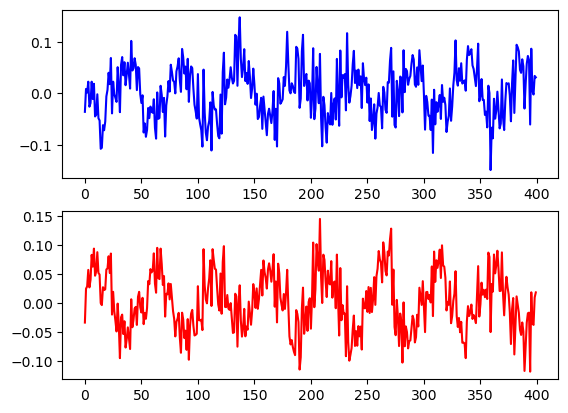

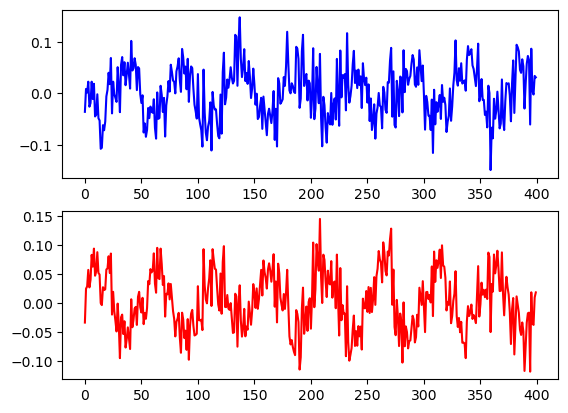

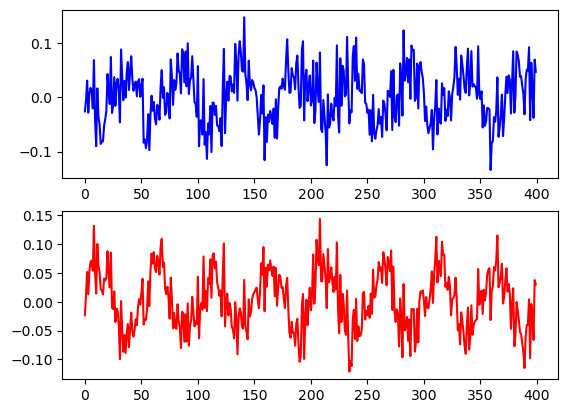

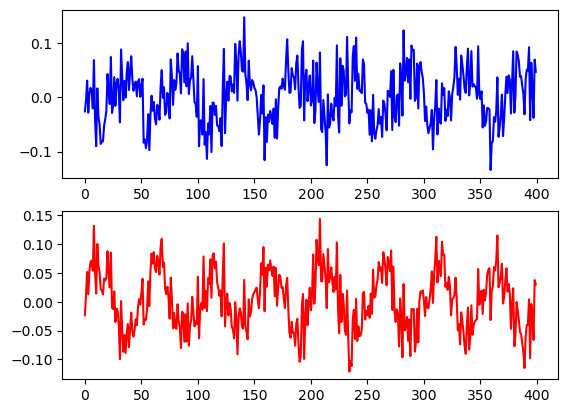

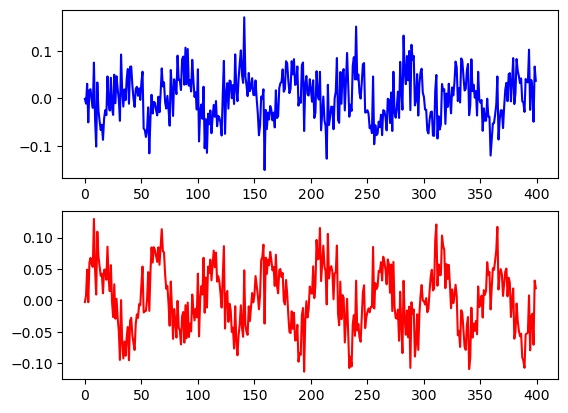

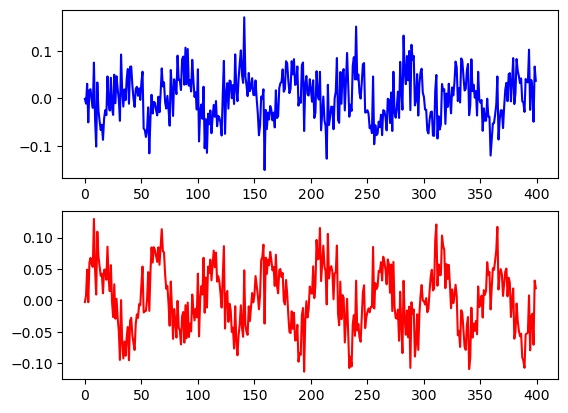

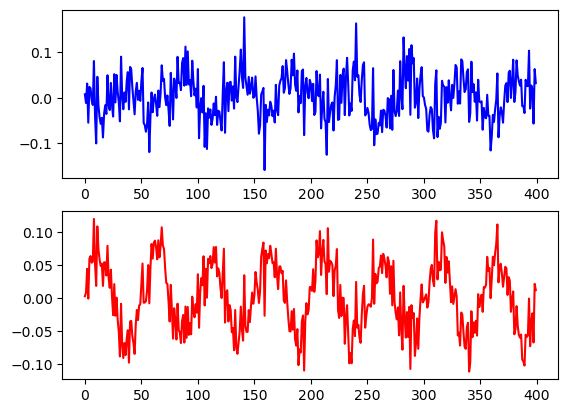

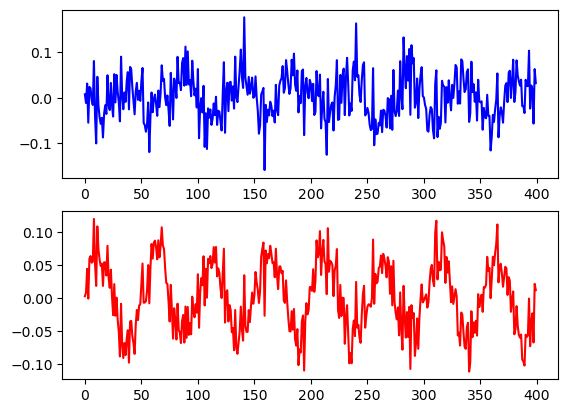

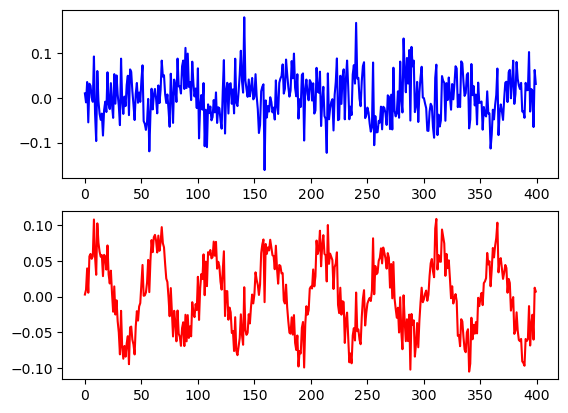

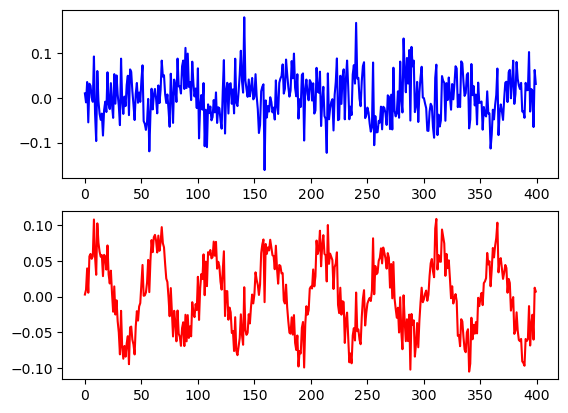

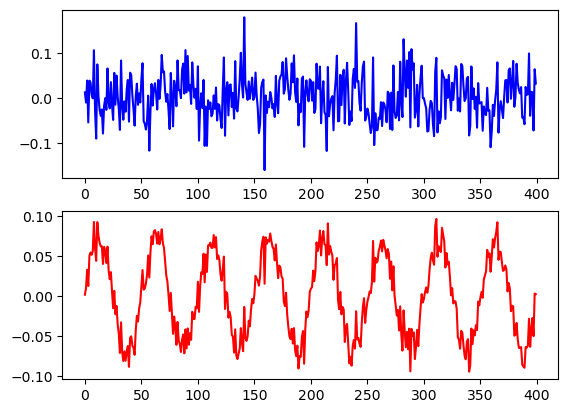

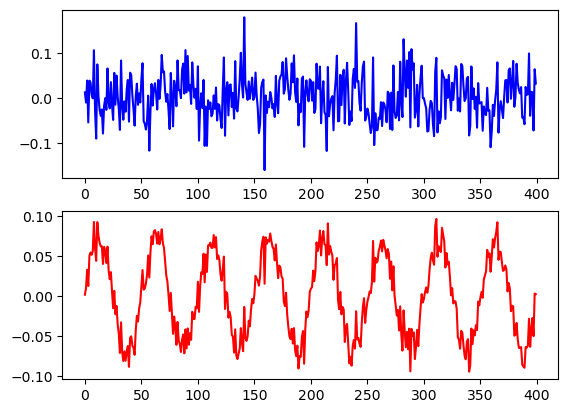

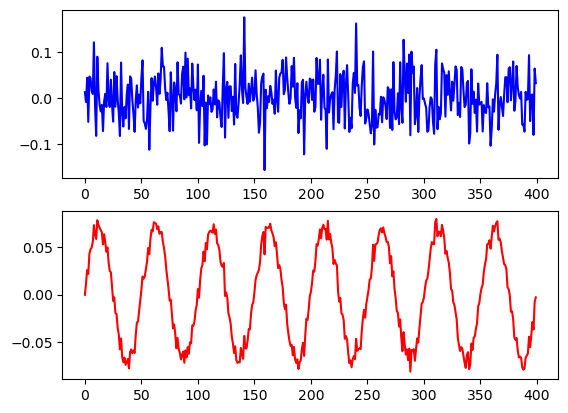

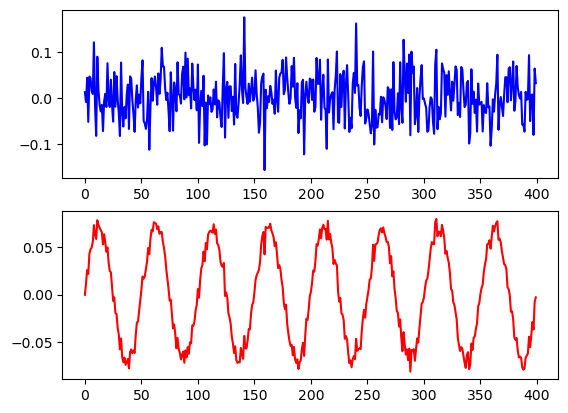

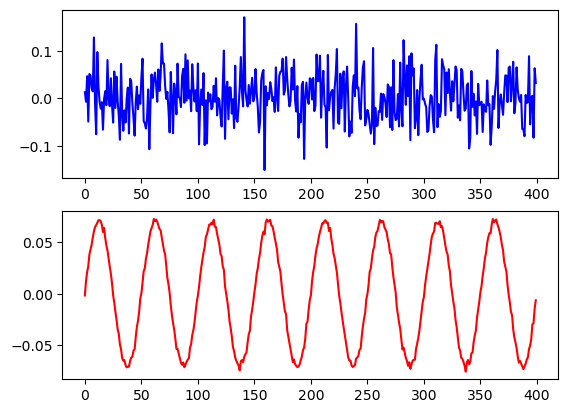

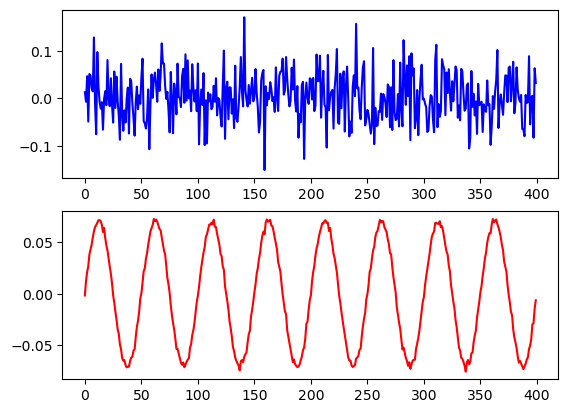

Done with training


In [29]:
n_iterations = 10000
X_train = torch.tensor(xmat.T,dtype=torch.float32)
hidden=torch.matmul(X_train,W)
X_test = X_train
codings = hidden

col = ['b','r','g','c','m','y','k']

for iteration in range(n_iterations):
  hidden=torch.matmul(X_train,W)
  outputs=torch.matmul(hidden,torch.transpose(W,0,1))
  reconstruction_loss=torch.mean(torch.square(outputs-X_train))

  optimizer.zero_grad()
  reconstruction_loss.backward()
  optimizer.step()

  if iteration%1000==0:
    plt.clf()
    for k in range(n_hidden):
      plt.subplot(n_hidden,1,k+1)
      plt.plot(W.detach().numpy()[:,k],col[k % len(col)])
    plt.show(False)
    plt.pause(0.001)

  codings=torch.matmul(X_test,W)
  outputs_eval=torch.matmul(codings,torch.transpose(W,0,1))
  reconstruction_loss_eval=torch.mean(torch.square(outputs_eval-X_test))

  codings_val = codings.detach().numpy()

print("Done with training")

##### Question 1 (5 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

##### Answer:

An autoencoder is a type of neural network that learns to encode input data into a lower-dimensional representation (encoding) and then decode it back to reconstruct the original input. It consists of two main parts: an encoder that compresses the input into a latent-space representation, and a decoder that reconstructs the input from this representation.

In this implementation, the encoder is represented by the matrix multiplication of X_train with W, creating the "hidden" or "codings" variable, while the decoder is represented by multiplying these codings with the transpose of W.

Ideally, if we pass a portion of signal x through the trained network, the network would first encode it into a lower-dimensional representation (in this case, 2 dimensions as defined by n_hidden = 2), and then decode it back to reconstruct the original signal with minimal loss of information. The reconstructed signal would preserve the most important features of the original signal while filtering out noise, effectively acting as a denoising mechanism for the sinusoidal signal contaminated with random noise.



##### Question 2 (5 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

##### Answer:
 
Based on the code, n_inputs = np.shape(xmat)[0] which is 400, and X_train = torch.tensor(xmat.T, dtype=torch.float32).

The variable xmat is created by buffering the audio signal x using the buffer function, which creates a matrix where each column represents a window of the audio signal. The buffer function uses a window size of 400 samples and a hop size of 200 samples.

When xmat is transposed (xmat.T) to create X_train, each row of X_train represents one window of the audio signal. Therefore, in a single forward pass, the network receives a batch of these windows, where each window is a 400-dimensional vector representing a segment of the audio signal (a mixture of sine wave and noise).
 
The dimensions of X_train are [number of windows, 400], and each forward pass processes all these windows simultaneously through the weight matrix W of shape [400, 2].


##### Question 3 (5 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

##### Answer:

The network weights are represented by the variable W, which is initialized as a torch.Variable with requires_grad=True to enable gradient computation during backpropagation. The weights are initialized using a normal distribution with mean 0 and standard deviation 0.1, creating a matrix of shape (400, 2) where 400 is the input dimension (window size) and 2 is the number of hidden units (n_hidden). This initialization is done with the line: W=Variable(torch.normal(0, 0.1, (400,2)), requires_grad=True).



##### Question  4 (5 points)

What is being minimized in the reconstruction loss? Why is this helpful?

##### Answer:

The reconstruction loss minimizes the mean squared error between the original input data (X_train) and the reconstructed output (outputs). Specifically, it calculates the average of the squared differences between each element of the original input and its corresponding reconstructed value.

This is helpful because:
1. It forces the network to learn an efficient encoding of the data in the lower-dimensional space (n_hidden = 2)
2. Since our input signal contains a sine wave with noise, minimizing reconstruction loss helps the network learn to represent the underlying sine wave pattern while filtering out random noise
3. It enables unsupervised learning - no labels are needed, just the input data itself
4. The lower-dimensional representation (codings) can reveal the intrinsic structure of the data, potentially separating the sine wave components from noise


##### Question 5 (5 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training? 

##### Answer:

An optimizer is an algorithm used to adjust the parameters (weights and biases) of a neural network during training to minimize the loss function. It determines how the model's parameters are updated based on the gradients computed during backpropagation.

Three common optimizers in deep learning are:

1. **Stochastic Gradient Descent (SGD)**: The simplest optimizer that updates parameters in the opposite direction of the gradient with a fixed learning rate. It can be enhanced with momentum to accelerate convergence.

2. **Adam (Adaptive Moment Estimation)**: Combines the benefits of AdaGrad and RMSProp by maintaining adaptive learning rates for each parameter using both first-order (mean) and second-order (uncentered variance) moments of the gradients.

3. **RMSProp (Root Mean Square Propagation)**: Maintains a moving average of squared gradients for each parameter and divides the learning rate by the square root of this average, helping to handle different scales of gradients.

4. **AdamW**: Combines the benefits of Adam and weight decay regularization. It uses Adam's adaptive learning rates but adds a weight decay term to the update equation.

In this autoencoder training, the **Adam optimizer** is used, as seen in the code:

##### Question 6 (5 points)

Why is X_test set to X_train? 

##### Answer:

In this autoencoder implementation, X_test is set equal to X_train (X_test = X_train) because the model is being evaluated on the same data it was trained on. This means we're not using a separate test set to evaluate the model's generalization capabilities.

This approach has important implications for evaluation:
1. We're measuring the reconstruction ability on the training data itself, which tells us how well the model can compress and reconstruct the specific patterns it was trained to recognize.
2. We're not evaluating how well the model generalizes to unseen data, which would typically be done with a separate test set.
3. This is common in unsupervised learning scenarios like autoencoders where the goal is to learn efficient representations of the input data rather than to make predictions on new data.
4. The reconstruction_loss_eval metric calculated using X_test is essentially measuring the same thing as the training loss, just at a different point in the training loop.


We can examine now the "codings", i.e. the hidden unit values and their distribution. The more signigicant codings should have smaller variances.

mean:  [-0.02060536 14.0797    ]
variance [0.77603126 0.3312787 ]


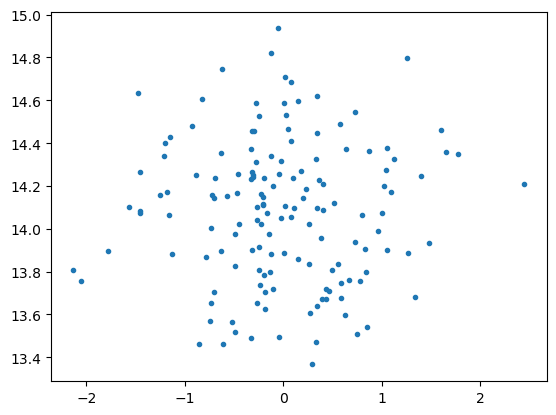

In [30]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

##### Question 7 (5 points)

In what way does the autoencoder network function similarly to PCA?

##### Answer:

The autoencoder network functions similarly to PCA in several key ways:

1. Dimensionality reduction: Both techniques compress high-dimensional data into a lower-dimensional representation (latent space) while preserving essential information.
2. Information preservation: Both prioritize capturing the most important variations in the data. PCA explicitly maximizes variance, while autoencoders minimize reconstruction error.
3. Linear transformations: In a single-layer autoencoder with linear activation functions, the learned representation is mathematically equivalent to PCA. The weight matrices of the encoder effectively learn the principal component directions.
4. Data reconstruction: Both methods allow reconstruction of the original data from the compressed representation, with some information loss that increases as the dimensionality of the latent space decreases.
5. Unsupervised learning: Both techniques learn patterns from unlabeled data without requiring explicit target outputs.

The key difference is that autoencoders can learn non-linear transformations through multiple layers and non-linear activation functions, potentially capturing more complex patterns than PCA's strictly linear transformations.


##### Extra Credit (10 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network? 


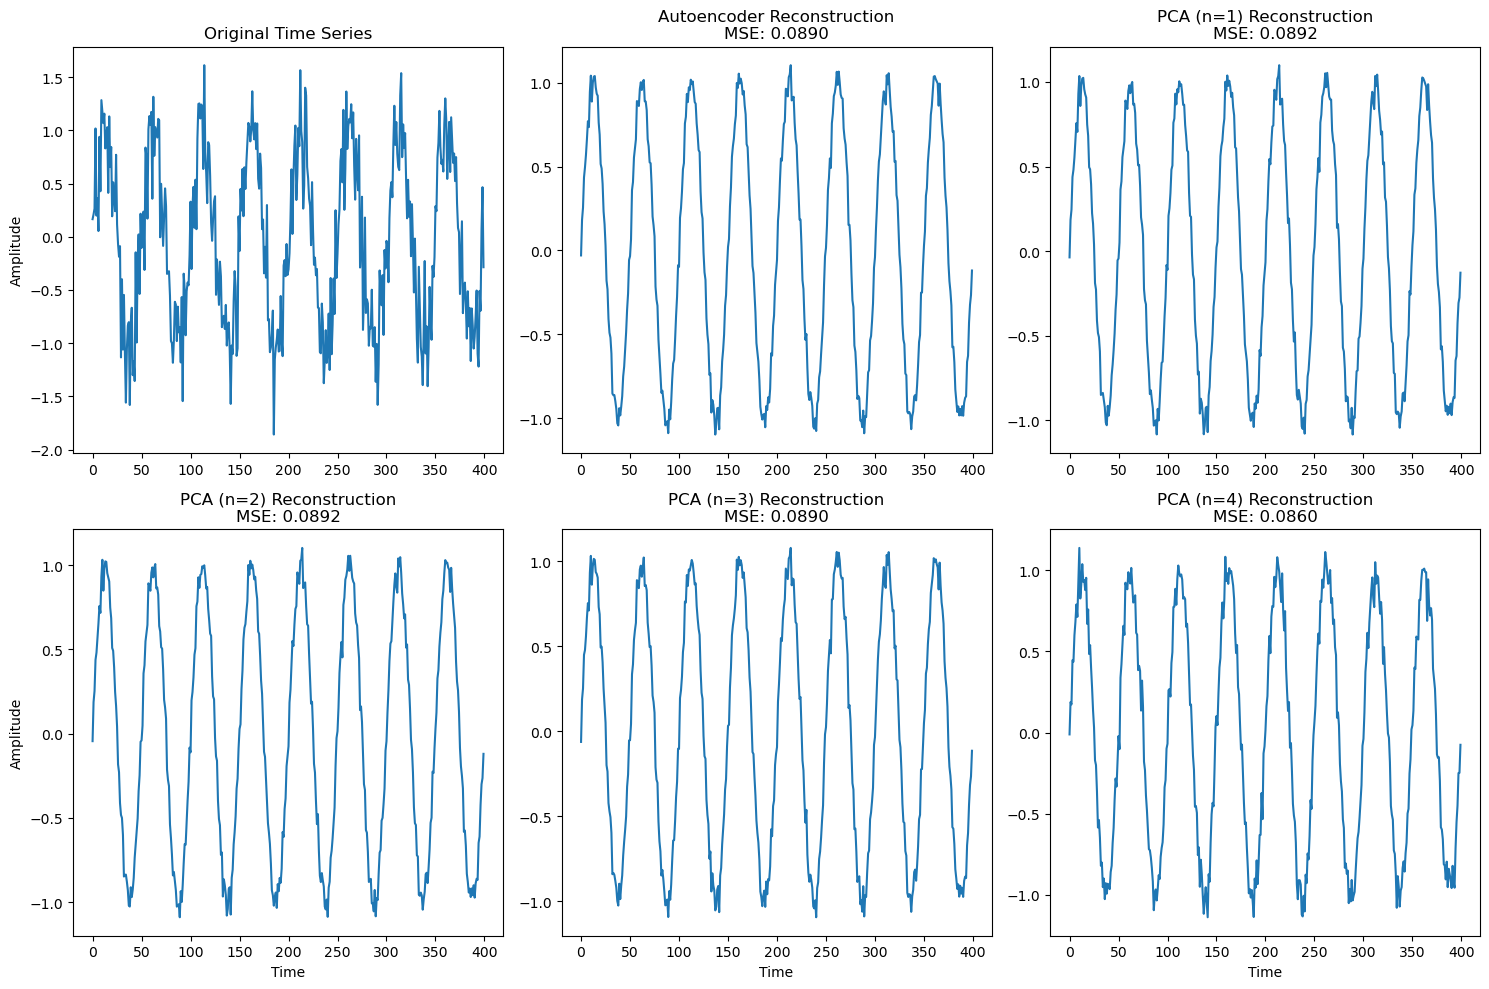

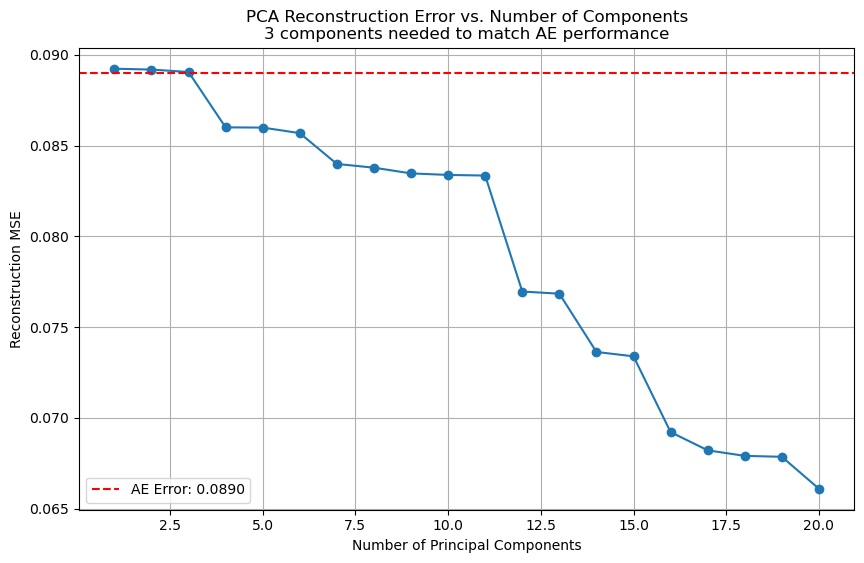

The autoencoder with 2 latent dimensions achieves an MSE of 0.0890
To achieve similar performance, PCA needs approximately 3 principal components


In [34]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Select a single sample for comparison
sample_idx = 0
single_sample = X_test[sample_idx:sample_idx+1]
single_sample_np = single_sample.numpy().flatten()

# Get the autoencoder reconstruction for this sample
codings = torch.matmul(single_sample, W)
ae_reconstruction = torch.matmul(codings, torch.transpose(W, 0, 1))
ae_reconstruction = ae_reconstruction.detach().numpy().flatten()

# Calculate autoencoder error
ae_error = ((single_sample_np - ae_reconstruction)**2).mean()

# Fit PCA with maximum number of components we'll need
max_components = 20
pca = PCA(n_components=max_components)
pca.fit(X_train)

# Create figure for comparing reconstructions with different PCA components
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original time series
axes[0, 0].plot(single_sample_np)
axes[0, 0].set_title('Original Time Series')
axes[0, 0].set_ylabel('Amplitude')

# Autoencoder reconstruction
axes[0, 1].plot(ae_reconstruction)
axes[0, 1].set_title(f'Autoencoder Reconstruction\nMSE: {ae_error:.4f}')

# PCA reconstructions with different numbers of components
pca_components = [1, 2, 3, 4]
pca_errors = []

# Transform the sample to PCA space
pca_transformed = pca.transform(single_sample_np.reshape(1, -1))

for i, n_comp in enumerate(pca_components):
    # Determine subplot position
    row, col = (0, 2) if i == 0 else (1, i-1)
    
    # Reconstruct using only n_comp components
    # Since PCA is deterministic, we can just use the first n_comp components
    truncated_transformed = np.copy(pca_transformed)
    truncated_transformed[0, n_comp:] = 0  # Zero out components we don't want to use
    pca_reconstruction = pca.inverse_transform(truncated_transformed).flatten()
    
    # Calculate error
    error = ((single_sample_np - pca_reconstruction)**2).mean()
    pca_errors.append(error)
    
    # Plot reconstruction
    axes[row, col].plot(pca_reconstruction)
    axes[row, col].set_title(f'PCA (n={n_comp}) Reconstruction\nMSE: {error:.4f}')
    
    # Add labels
    if col == 0:
        axes[row, col].set_ylabel('Amplitude')
    if row == 1:
        axes[row, col].set_xlabel('Time')

plt.tight_layout()
plt.show()

# Calculate errors for all component counts we want to analyze
n_components_range = range(1, max_components + 1)
all_pca_errors = []

for n in n_components_range:
    # Use the same transformed data, just truncate to n components
    truncated_transformed = np.copy(pca_transformed)
    truncated_transformed[0, n:] = 0
    pca_reconstruction = pca.inverse_transform(truncated_transformed).flatten()
    error = ((single_sample_np - pca_reconstruction)**2).mean()
    all_pca_errors.append(error)

matching_components = np.argmin(np.abs(np.array(all_pca_errors) - ae_error)) + 1

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, all_pca_errors, marker='o')
plt.axhline(y=ae_error, color='r', linestyle='--', label=f'AE Error: {ae_error:.4f}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction MSE')
plt.title(f'PCA Reconstruction Error vs. Number of Components\n{matching_components} components needed to match AE performance')
plt.grid(True)
plt.legend()
plt.show()

print(f"The autoencoder with {codings.shape[1]} latent dimensions achieves an MSE of {ae_error:.4f}")
print(f"To achieve similar performance, PCA needs approximately {matching_components} principal components")

##### Observation:
 
The autoencoder with 2 latent dimensions achieves an MSE of 0.0890, while PCA requires approximately 3 principal components to achieve similar reconstruction performance. This suggests that autoencoders can potentially capture more information in fewer dimensions compared to PCA, likely due to their ability to learn non-linear transformations. The non-linear activation functions in the neural network allow the autoencoder to represent complex patterns more efficiently than PCA's linear transformations.
 
However, it's important to note that this observation is based on a single sample, which limits the generalizability of our conclusion. A more robust analysis would require evaluating performance across the entire dataset and potentially with different architectures. Additionally, while autoencoders may achieve better compression in this case, PCA offers other advantages such as interpretability and computational efficiency that should be considered when choosing between these dimensionality reduction techniques.
